Previous studies have found correlations between weight loss and higher mortality:

Park SY, Wilkens LR, Maskarinec G, Haiman CA, Kolonel LN, Marchand LL. Weight change in older adults and mortality: the Multiethnic Cohort Study. Int J Obes (Lond). 2018 Feb;42(2):205-212. doi: 10.1038/ijo.2017.188. Epub 2017 Aug 14. PMID: 28885999; PMCID: PMC5803382.

Hussain SM, Newman AB, Beilin LJ, Tonkin AM, Woods RL, Neumann JT, Nelson M, Carr PR, Reid CM, Owen A, Ball J, Cicuttini FM, Tran C, Wang Y, Ernst ME, McNeil JJ. Associations of Change in Body Size With All-Cause and Cause-Specific Mortality Among Healthy Older Adults. JAMA Netw Open. 2023 Apr 3;6(4):e237482. doi: 10.1001/jamanetworkopen.2023.7482. PMID: 37036703; PMCID: PMC10087052.

First, had to load and then clean the dataframe. Steps are shown below. Dropped the Section GG columns because nearly all are empty and contain unneeded information anyway. Code needs to be modified for datasets with different formats or if more restrictions/cleaning is wanted. Also I'm sure FT_problem is fall history?

In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)

# get the dataset as a datafram
df = pd.read_csv('MDS sample.csv').drop(['GG0130A1_EATG_ABILITY_STRT_CD','GG0130A2_EATG_GOAL_BY_END_CD','GG0130A3_EATG_ABILITY_END_CD',
                                         'GG0130A5_SELF_CARE_EATG_CD','GG0130B1_ORAL_ABILITY_STRT_CD','GG0130B2_ORAL_GOAL_BY_END_CD','GG0130B3_ORAL_ABILITY_END_CD','GG0130B5_SELF_CARE_ORAL_CD','GG0130C1_TOILT_ABILITY_STRT_CD',
                                         'GG0130C2_TOILT_GOAL_BY_END_CD','GG0130C3_TOILT_ABILITY_END_CD','GG0130C5_SELF_CARE_TOILTG_CD',
                                         'GG0130E1_BTHE_SELF_STRT_CD','GG0130E2_BTHE_SELF_GOAL_CD','GG0130E3_BTHE_SELF_END_CD','GG0130F1_UPR_DRSNG_STRT_CD',
                                         'GG0130F2_UPR_DRSNG_GOAL_CD','GG0130F3_UPR_DRSNG_END_CD','GG0130G1_LWR_DRSNG_STRT_CD','GG0130G2_LWR_DRSNG_GOAL_CD','GG0130G3_LWR_DRSNG_END_CD'], axis = 1)
# change dates into datetime datatypes
df['DATE_ASSESSMENT'] = pd.to_datetime(df['DATE_ASSESSMENT'], format='%d%b%Y', errors='coerce')
df['BENE_DEATH_DT'] = pd.to_datetime(df['BENE_DEATH_DT'], format='%d%b%Y',errors='coerce')
# change weight recordings of 0 into NaN
df['WT_OLD'] = df['WT_OLD'].replace(0, np.nan)
# sort the assessments of each person by the date
df_sorted = df.sort_values(by=['BENE_ID', 'DATE_ASSESSMENT'], ascending=[True, False]).reset_index(drop=True)



# convert the values in RACE column so that it shows the race instead of the corresponding number
race_map = {
    6: "Native Hawaiian/Pacific Islander",
    5: "American Indian/Alaskan Native",
    4: "Asian",
    3: "Black",
    2: "Hispanic",
    1: "White",
    0: "Missing"
}
df_sorted["RACE"] = df_sorted["RACE"].map(race_map)

#c onvert values in GENDER column to actual genders instead of A and B
gender_map = {
    'A': 'Male',
    'B': 'Female'
}
df_sorted["GENDER"] = df_sorted["GENDER"].map(gender_map)

#find row with earliest assessment for each patient
first_assessment = (df_sorted.sort_values(["BENE_ID", "DATE_ASSESSMENT"], ascending=[True, True])
    .groupby('BENE_ID', group_keys=False)
    .apply(lambda g: g.iloc[0])
    .reset_index(drop=True)
)
# drop under 66 years old
mask_age = first_assessment["AGE"] >= 66
# drop missing WT_OLD at first assessment
mask_wt_notna = first_assessment["WT_OLD"].notna()
# drop outside 1st–99th percentile in WT_OLD
low, high = first_assessment["WT_OLD"].quantile([0.01, 0.99])
mask_wt_range = first_assessment["WT_OLD"].between(low, high)
# drop BMI < 30
mask_bmi = first_assessment["BMI"] >= 30
# combine masks
valid_patients = first_assessment[mask_age & mask_wt_notna & mask_wt_range & mask_bmi]["BENE_ID"]
# keep only assessments for valid patients
df_sorted = df_sorted[df_sorted["BENE_ID"].isin(valid_patients)].copy()




df_sorted[df_sorted['BENE_ID'].str.contains('JJJJJJzpSzM3ppJ')]
#df_sorted[df_sorted['BENE_ID'].str.contains('JJJJJJJM3zMz3oo')].sort_values(["BENE_ID", "DATE_ASSESSMENT"]).groupby("BENE_ID").first().reset_index()
#df_sorted[df_sorted['BENE_ID'].str.contains('JJJJJJJozWpzopV')]
#len(df_sorted)



/var/folders/0y/mmp_lnms4tx1tvdz0cwsqdx40000gs/T/ipykernel_13730/4024188056.py:7: DtypeWarning: Columns (41,43,44,46,47,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('MDS sample.csv').drop(['GG0130A1_EATG_ABILITY_STRT_CD','GG0130A2_EATG_GOAL_BY_END_CD','GG0130A3_EATG_ABILITY_END_CD',
/var/folders/0y/mmp_lnms4tx1tvdz0cwsqdx40000gs/T/ipykernel_13730/4024188056.py:44: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.iloc[0])


,BENE_ID,DATE_ASSESSMENT,BENE_DEATH_DT,AGE,GENDER,RACE,ADL_SCORE,MOBILITY_SP1,COG_MS1,ARTHRITIS,STROKE,CANCER,COPD,DIAB,DEMENTIA,WT_OLD,BMI,DEPRESSION,HEARTFAILURE,HYPERTENSION,ESRD,FT_PROBLEM,HEARING,BOWEL_INCONTINENCE,URINE_INCONTINENCE,ANXTY,MNC_DPRSN,SCHZOPRNIA,BIMS,PRESSURE_ULCER
59664,JJJJJJzpSzM3ppJ,2020-03-08,2020-06-29,71,Female,White,16.0,3.0,NaN,Arthritis,NaN,NaN,NaN,Diabetes,Dementia,71.667536,28.895421,Depression,Heart failure,Hypertension,End-stage renal disease,Fall history,NaN,NaN,Urinary incontinence,NaN,NaN,NaN,Mildly impaired,NaN
59665,JJJJJJzpSzM3ppJ,2019-12-09,2020-06-29,71,Female,White,16.0,3.0,2.0,NaN,NaN,NaN,NaN,Diabetes,Dementia,76.203456,30.724246,Depression,Heart failure,Hypertension,End-stage renal disease,Fall history,NaN,NaN,Urinary incontinence,NaN,NaN,NaN,Moderately impaired,NaN
59666,JJJJJJzpSzM3ppJ,2019-09-08,2020-06-29,71,Female,White,19.0,3.0,2.0,NaN,NaN,NaN,NaN,Diabetes,NaN,77.564232,31.272893,Depression,Heart failure,Hypertension,NaN,Fall history,NaN,NaN,Urinary incontinence,NaN,NaN,NaN,Moderately impaired,NaN
59667,JJJJJJzpSzM3ppJ,2019-06-08,2020-06-29,71,Female,White,17.0,3.0,2.0,NaN,NaN,NaN,NaN,Diabetes,NaN,78.925008,31.821540,Depression,Heart failure,Hypertension,NaN,Fall history,NaN,NaN,Urinary incontinence,NaN,NaN,NaN,Moderately impaired,NaN
59668,JJJJJJzpSzM3ppJ,2019-03-08,2020-06-29,70,Female,White,18.0,3.0,2.0,NaN,NaN,NaN,NaN,Diabetes,NaN,88.450440,35.662071,Depression,Heart failure,Hypertension,End-stage renal disease,Fall history,NaN,NaN,Urinary incontinence,NaN,NaN,NaN,Moderately impaired,NaN
59669,JJJJJJzpSzM3ppJ,2019-02-07,2020-06-29,70,Female,White,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59670,JJJJJJzpSzM3ppJ,2019-02-04,2020-06-29,70,Female,White,19.0,3.0,1.0,NaN,NaN,NaN,NaN,Diabetes,NaN,90.264808,36.393600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Urinary incontinence,NaN,NaN,NaN,NaN,NaN
59671,JJJJJJzpSzM3ppJ,2018-12-08,2020-06-29,70,Female,White,17.0,3.0,NaN,NaN,Stroke,NaN,NaN,Diabetes,NaN,87.543256,35.296306,Depression,Heart failure,Hypertension,NaN,Fall history,NaN,Bowel incontinence,Urinary incontinence,NaN,NaN,NaN,Cognitively intact,NaN
59672,JJJJJJzpSzM3ppJ,2018-09-07,2020-06-29,70,Female,White,17.0,3.0,2.0,NaN,Stroke,NaN,NaN,Diabetes,NaN,84.821704,34.199011,Depression,Heart failure,Hypertension,NaN,Fall history,NaN,Bowel incontinence,Urinary incontinence,NaN,NaN,NaN,Moderately impaired,NaN
59673,JJJJJJzpSzM3ppJ,2018-06-07,2020-06-29,70,Female,White,19.0,3.0,2.0,NaN,NaN,NaN,NaN,Diabetes,NaN,86.636072,34.930541,Depression,Heart failure,Hypertension,NaN,Fall history,NaN,Bowel incontinence,Urinary incontinence,NaN,NaN,NaN,Moderately impaired,NaN


Creation of a summary dataframe that summarizes the information of each people in the cleaned dataset. If bene_death_dt is NaN that indicates a person didn't die during the 2 year period.

In [2]:

# define summary function for each person
def summarize_patient(group):

    # list of illness columns
    illness_cols = [
    'ARTHRITIS','STROKE','CANCER','COPD','DIAB','DEMENTIA','DEPRESSION',
    'HEARTFAILURE','HYPERTENSION','ESRD','FT_PROBLEM','HEARING',
    'BOWEL_INCONTINENCE','URINE_INCONTINENCE','ANXTY','MNC_DPRSN','SCHZOPRNIA','PRESSURE_ULCER'
    ]

    first_date = group['DATE_ASSESSMENT'].min()
    last_date = group['DATE_ASSESSMENT'].max()
    death_date = group['BENE_DEATH_DT'].min()
    months_between_assessments = (last_date.year - first_date.year) * 12 + (last_date.month - first_date.month)
    assessment1_death_between = (death_date.year - first_date.year) * 12 + (death_date.month - first_date.month) if death_date != np.nan else np.nan

    init_wt = group['WT_OLD'].dropna().iloc[-1] if group['WT_OLD'].notna().any() else np.nan
    end_wt =  group['WT_OLD'].dropna().iloc[0] if group['WT_OLD'].notna().any() else np.nan

    summary = {
        'INITIAL_AGE': group.loc[group['DATE_ASSESSMENT'] == first_date, 'AGE'].values[0],
        'BENE_DEATH_DT': group['BENE_DEATH_DT'].dropna().iloc[-1] if group['BENE_DEATH_DT'].notna().any() else np.nan,
        'GENDER': group['GENDER'].dropna().iloc[-1] if group['GENDER'].notna().any() else np.nan,
        'RACE': group['RACE'].dropna().iloc[-1] if group['RACE'].notna().any() else np.nan,
        'First_Assessment': first_date,
        'Last_Assessment': last_date,
        'Months_Between_Assessments': months_between_assessments,
        'assessment1_death_month_between': assessment1_death_between,
        'ADL_SCORE_INIT': group['ADL_SCORE'].dropna().iloc[-1] if group['ADL_SCORE'].notna().any() else np.nan,
        'MOBILITY_SP1_INIT':  group['MOBILITY_SP1'].dropna().iloc[-1] if group['MOBILITY_SP1'].notna().any() else np.nan,
        'COG_MS1_INIT':  group['COG_MS1'].dropna().iloc[-1] if group['COG_MS1'].notna().any() else np.nan,
        'Initial_BIMS': group['BIMS'].dropna().iloc[-1] if group['BIMS'].notna().any() else np.nan,
        'Initial_BMI': group['BMI'].dropna().iloc[-1] if group['BMI'].notna().any() else np.nan,
        'Initial_WT': init_wt,
        'End_WT': end_wt,
        'Overall_WT_Change': end_wt - init_wt,
        'Overall_WT_Change_Percent' : (end_wt - init_wt) / init_wt if group['WT_OLD'].notna().any() else np.nan
    }

    # illness present if any row has a non-null value (i checked and 
    # each col only contains either NaN or the name of the illness)
    for col in illness_cols:
        illness_present = group[col].notna().any()
        summary[col] = int(illness_present)

    # maximum weight loss experienced going from 1 assessment to the next (%)
    wt_series = group.sort_values('DATE_ASSESSMENT')['WT_OLD'].dropna()
    if len(wt_series) >= 2:
        # initial weight for denominator
        initial_wt = wt_series.iloc[0]
        # weight changes between successive assessments (negative = loss)
        wt_diffs = wt_series.diff()
        # largest (most negative) drop in kg
        max_drop_kg = wt_diffs.min()
        if pd.notna(initial_wt) and initial_wt > 0:
            summary['MOST_WT_LOSS'] = (max_drop_kg / initial_wt) * 100   # now stored as %
        else:
            summary['MOST_WT_LOSS'] = np.nan
    else:
        summary['MOST_WT_LOSS'] = np.nan

    return pd.Series(summary)

# apply group-by logic
summary_df = df_sorted.groupby('BENE_ID').apply(summarize_patient).reset_index()

summary_df


/var/folders/0y/mmp_lnms4tx1tvdz0cwsqdx40000gs/T/ipykernel_13730/3300553574.py:65: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary_df = df_sorted.groupby('BENE_ID').apply(summarize_patient).reset_index()


,BENE_ID,INITIAL_AGE,BENE_DEATH_DT,GENDER,RACE,First_Assessment,Last_Assessment,Months_Between_Assessments,assessment1_death_month_between,ADL_SCORE_INIT,MOBILITY_SP1_INIT,COG_MS1_INIT,Initial_BIMS,Initial_BMI,Initial_WT,End_WT,Overall_WT_Change,Overall_WT_Change_Percent,ARTHRITIS,STROKE,CANCER,COPD,DIAB,DEMENTIA,DEPRESSION,HEARTFAILURE,HYPERTENSION,ESRD,FT_PROBLEM,HEARING,BOWEL_INCONTINENCE,URINE_INCONTINENCE,ANXTY,MNC_DPRSN,SCHZOPRNIA,PRESSURE_ULCER,MOST_WT_LOSS
0,JJJJJJ43zVVWMVo,70,NaT,Female,Black,2018-01-26,2020-01-17,24,NaN,16.0,1.0,NaN,Cognitively intact,37.105089,101.151016,97.975872,-3.175144,-0.031390,0,0,0,1,1,1,1,1,1,0,1,0,0,0,1,0,0,0,-5.829596
1,JJJJJJ4J4WVppzz,72,NaT,Male,White,2018-01-19,2020-02-05,25,NaN,6.0,1.0,1.0,Mildly impaired,35.143027,114.305184,104.779752,-9.525432,-0.083333,0,0,0,1,1,0,1,1,1,1,1,0,1,1,0,1,0,0,-12.301587
2,JJJJJJ4JJ44WMS4,74,2020-10-10,Female,White,2019-11-14,2020-03-16,4,11.0,22.0,3.0,2.0,Moderately impaired,31.580078,83.460928,88.450440,4.989512,0.059783,1,1,0,0,1,1,1,1,1,0,1,0,1,1,0,1,0,0,-1.086957
3,JJJJJJ4JJ4oV3SM,73,NaT,Female,White,2018-01-04,2018-05-25,4,NaN,15.0,3.0,2.0,Moderately impaired,31.455775,78.017824,79.832192,1.814368,0.023256,0,0,0,1,0,0,1,1,1,0,1,0,1,1,1,0,0,0,-2.325581
4,JJJJJJ4JJoopJzM,69,NaT,Female,White,2018-02-13,2020-03-30,25,NaN,18.0,2.0,2.0,Moderately impaired,39.446111,91.625584,90.718400,-0.907184,-0.009901,1,0,0,0,1,1,1,0,1,0,1,0,1,1,0,0,0,0,-9.900990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,JJJJJJzp33J3SMz,71,2018-09-18,Male,Black,2018-01-17,2018-07-04,6,8.0,13.0,1.0,3.0,Severely impaired,33.245638,93.439952,90.718400,-2.721552,-0.029126,0,0,0,0,1,1,1,0,1,0,1,0,1,1,0,0,1,0,-1.941748
426,JJJJJJzpMM4Mzpz,66,NaT,Male,White,2018-02-07,2020-03-03,25,NaN,22.0,3.0,0.0,Mildly impaired,32.535035,97.068688,98.429464,1.360776,0.014019,1,0,0,0,0,0,0,1,1,0,1,0,1,1,0,0,0,0,-2.336449
427,JJJJJJzpSSzzMz4,71,2021-01-20,Female,White,2018-01-03,2020-03-16,26,36.0,7.0,1.0,2.0,Cognitively intact,31.147612,87.543256,94.347136,6.803880,0.077720,1,0,0,0,1,1,0,1,1,1,1,0,1,1,0,0,0,0,-9.326425
428,JJJJJJzpSzM3ppJ,69,2020-06-29,Female,White,2018-01-08,2020-03-08,26,29.0,18.0,3.0,2.0,Moderately impaired,35.479188,87.996848,71.667536,-16.329312,-0.185567,1,1,0,0,1,1,1,1,1,1,1,0,1,1,0,0,0,0,-14.948454


Creation of a summary table that divides the population into 3 groups (all residents, residents who lost 10% or more weight from initial assessment after 1 year to last assessment, and residents who lost less than 10% weight from initial assessment after 1 year to last assessment) and gives summary statistics for each in both raw values and percents. First row shows how the population is divided up. 

In [3]:
def create_summary_table(df):
    # initialize the summary dataframe
    summary = pd.DataFrame(columns=[
        'Category', 
        'All_N', 'All_%', 
        'Weight_Loss_N', 'Weight_Loss_%', 
        'No_Weight_Loss_N', 'No_Weight_Loss_%'
    ])
    
    # define groups
    total_residents = len(df)
    weight_loss_df = df[df['Overall_WT_Change_Percent'] <= -0.1]
    no_weight_loss_df = df[df['Overall_WT_Change_Percent'] > -0.1]
    
    total_wl = len(weight_loss_df)
    total_no_wl = len(no_weight_loss_df)
    
    # helper function to add rows
    def add_row(category, mask):
        n_all = mask.sum()
        n_wl = mask[weight_loss_df.index].sum()
        n_no_wl = mask[no_weight_loss_df.index].sum()
        
        return pd.DataFrame({
            'Category': [category],
            'All_N': [n_all],
            'All_%': [f"{(n_all/total_residents)*100:.1f}%"],
            'Weight_Loss_N': [n_wl],
            'Weight_Loss_%': [f"{(n_wl/total_wl)*100:.1f}%" if total_wl > 0 else "0.0%"],
            'No_Weight_Loss_N': [n_no_wl],
            'No_Weight_Loss_%': [f"{(n_no_wl/total_no_wl)*100:.1f}%" if total_no_wl > 0 else "0.0%"]
        })
    
    # mortality for groups
    mortality_mask = df['BENE_DEATH_DT'].notna()
    summary = pd.concat([summary, add_row("Mortality", mortality_mask)], ignore_index=True)
    
    # obesity groups
    bmi_bins = [0, 30, 35, 40, 200]
    obesity_labels = ['Non-obese', 'Class I', 'Class II', 'Class III']
    df['obesity_group'] = pd.cut(df['Initial_BMI'], bins=bmi_bins, labels=obesity_labels)
    
    for obesity_group in obesity_labels:
        mask = (df['obesity_group'] == obesity_group)
        summary = pd.concat([summary, add_row(f"Obesity {obesity_group}", mask)], ignore_index=True)

    # age groups
    age_bins = [0, 64, 74, 84, 94, 120]
    age_labels = ['<65', '65-74', '75-84', '85-94', '≥95']
    df['age_group'] = pd.cut(df['INITIAL_AGE'], bins=age_bins, labels=age_labels)
    
    for age_group in age_labels:
        mask = (df['age_group'] == age_group)
        summary = pd.concat([summary, add_row(f"Age {age_group}", mask)], ignore_index=True)

    # gender 
    for gender in df['GENDER'].dropna().unique():
        mask = (df['GENDER'] == gender)
        summary = pd.concat([summary, add_row(f"Gender {gender}", mask)], ignore_index=True)

    # race
    for race in df['RACE'].dropna().unique():
        mask = (df['RACE'] == race)
        summary = pd.concat([summary, add_row(f"Race {race}", mask)], ignore_index=True)

    # ADL impairment
    adl_bins = [0, 12, 20, 28]
    adl_labels = ['Mild (0-12)', 'Moderate (13-20)', 'Severe (21-28)']
    df['ADL_category'] = pd.cut(df['ADL_SCORE_INIT'], bins=adl_bins, labels=adl_labels)
    
    for adl_cat in adl_labels:
        mask = (df['ADL_category'] == adl_cat)
        summary = pd.concat([summary, add_row(f"ADL {adl_cat}", mask)], ignore_index=True)

    # mobility
    mobility_map = {
        0: 'No impairment',
        1: 'Mild impairment',
        2: 'Moderate impairment',
        3: 'Severe impairment'
    }
    df['MOBILITY_category'] = df['MOBILITY_SP1_INIT'].round().map(mobility_map)
    
    for mob_cat in mobility_map.values():
        mask = (df['MOBILITY_category'] == mob_cat)
        summary = pd.concat([summary, add_row(f"Mobility {mob_cat}", mask)], ignore_index=True)

    # cognitive function
    for cog_cat in df['Initial_BIMS'].dropna().unique():
        mask = (df['Initial_BIMS'] == cog_cat)
        summary = pd.concat([summary, add_row(f"Cognitive {cog_cat}", mask)], ignore_index=True)

    # medical conditions
    conditions = [
        'ARTHRITIS', 'STROKE', 'CANCER', 'COPD', 'DIAB', 'DEMENTIA', 
        'DEPRESSION', 'HEARTFAILURE', 'HYPERTENSION', 'ESRD',
        'FT_PROBLEM', 'HEARING', 'BOWEL_INCONTINENCE', 
        'URINE_INCONTINENCE', 'ANXTY', 'MNC_DPRSN', 'SCHZOPRNIA','PRESSURE_ULCER'
    ]
    
    for condition in conditions:
        if condition in df.columns:
            mask = (df[condition] == 1)
            summary = pd.concat([summary, add_row(condition, mask)], ignore_index=True)

    # total row
    total_row = pd.DataFrame({
        'Category': ['Summary Residents'],
        'All_N': [total_residents],
        'All_%': ['100%'],
        'Weight_Loss_N': [total_wl],
        'Weight_Loss_%': [str((round((total_wl/total_residents)*100, ndigits=1))) + '%' if total_wl > 0 else '0.0%'],
        'No_Weight_Loss_N': [total_no_wl],
        'No_Weight_Loss_%': [str((total_no_wl/total_residents)*100) + '%' if total_no_wl > 0 else '0.0%']
    })
    
    summary = pd.concat([total_row, summary]).reset_index(drop=True)
    
    return summary

summary_table = create_summary_table(summary_df)
summary_table



,Category,All_N,All_%,Weight_Loss_N,Weight_Loss_%,No_Weight_Loss_N,No_Weight_Loss_%
0,Summary Residents,430,100%,119,27.7%,311,72.32558139534883%
1,Mortality,213,49.5%,79,66.4%,134,43.1%
2,Obesity Non-obese,0,0.0%,0,0.0%,0,0.0%
3,Obesity Class I,235,54.7%,53,44.5%,182,58.5%
4,Obesity Class II,110,25.6%,33,27.7%,77,24.8%
5,Obesity Class III,85,19.8%,33,27.7%,52,16.7%
6,Age <65,0,0.0%,0,0.0%,0,0.0%
7,Age 65-74,149,34.7%,38,31.9%,111,35.7%
8,Age 75-84,161,37.4%,49,41.2%,112,36.0%
9,Age 85-94,110,25.6%,30,25.2%,80,25.7%


Checking distributions of Initial Weight and Overall WT Change %

In [4]:
def create_summary_table_formatted(df):
    summary = pd.DataFrame(columns=[
        'Category',
        'All sample',
        'Excessive weight loss',
        'No excessive weight loss'
    ])

    # define groups
    all_df = df
    wl_df = df[df['Overall_WT_Change_Percent'] <= -0.1]
    no_wl_df = df[df['Overall_WT_Change_Percent'] > -0.1]

    def n_pct(mask, sub_df):
        n = mask.loc[sub_df.index].sum()
        pct = (n / len(sub_df)) * 100 if len(sub_df) > 0 else 0
        return f"{n} ({pct:.1f}%)"
    
    def mean_sd(series):
        return f"{series.mean():.1f} ({series.std():.1f})"
    
    def add_row(category, mask):
        return pd.DataFrame({
            'Category': [category],
            'All sample': [n_pct(mask, all_df)],
            'Excessive weight loss': [n_pct(mask, wl_df)],
            'No excessive weight loss': [n_pct(mask, no_wl_df)]
        })
    
    def add_mean_row(category, col):
        return pd.DataFrame({
            'Category': [category],
            'All sample': [mean_sd(all_df[col])],
            'Excessive weight loss': [mean_sd(wl_df[col])],
            'No excessive weight loss': [mean_sd(no_wl_df[col])]
        })
    

    # ---- Mortality ----
    summary = pd.concat([
        summary,
        add_row("Mortality", df['BENE_DEATH_DT'].notna())
    ], ignore_index=True)

    # ---- Obesity groups ----
    bmi_bins = [30, 35, 40, 200]
    obesity_labels = ['Class I', 'Class II', 'Class III']
    df['obesity_group'] = pd.cut(df['Initial_BMI'], bins=bmi_bins, labels=obesity_labels)

    for grp in obesity_labels:
        summary = pd.concat([
            summary,
            add_row(f"Obesity {grp}", df['obesity_group'] == grp)
        ], ignore_index=True)

    # ---- Age groups ----
    summary = pd.concat([
        summary,
        add_mean_row("Age, mean (SD)", 'INITIAL_AGE'),
    ], ignore_index=True)
    
    age_bins = [64, 74, 84, 94, 120]
    age_labels = ['65–74', '75–84', '85–94', '≥95']
    df['age_group'] = pd.cut(df['INITIAL_AGE'], bins=age_bins, labels=age_labels)

    for grp in age_labels:
        summary = pd.concat([
            summary,
            add_row(f"Age {grp}", df['age_group'] == grp)
        ], ignore_index=True)

    # ---- Gender ----
    for gender in sorted(df['GENDER'].dropna().unique()):
        summary = pd.concat([
            summary,
            add_row(f"Gender {gender}", df['GENDER'] == gender)
        ], ignore_index=True)

    # ---- Race / ethnicity ----
    summary = pd.concat([
        summary,
        add_row("Race White", df['RACE'] == 'White'),
        add_row("Race Black", df['RACE'] == 'Black'),
        add_row("Race Hispanic", df['RACE'] == 'Hispanic'),
        add_row("Race Other", ~df['RACE'].isin(['White', 'Black', 'Hispanic']))
    ], ignore_index=True)

    # ---- ADL ----
    adl_bins = [0, 12, 20, 28]
    adl_labels = ['Mild (0–12)', 'Moderate (13–20)', 'Severe (21–28)']
    df['ADL_category'] = pd.cut(df['ADL_SCORE_INIT'], bins=adl_bins, labels=adl_labels)

    for grp in adl_labels:
        summary = pd.concat([
            summary,
            add_row(f"ADL {grp}", df['ADL_category'] == grp)
        ], ignore_index=True)

    # ---- Mobility ----
    mobility_map = {
        0: 'No impairment',
        1: 'Mild impairment',
        2: 'Moderate impairment',
        3: 'Severe impairment'
    }
    df['MOBILITY_category'] = df['MOBILITY_SP1_INIT'].round().map(mobility_map)

    for mob_cat in mobility_map.values():
        summary = pd.concat([
            summary,
            add_row(f"Mobility {mob_cat}", df['MOBILITY_category'] == mob_cat)
        ], ignore_index=True)

    # ---- Cognitive status ----
    for cog_cat in sorted(df['Initial_BIMS'].dropna().unique()):
        summary = pd.concat([
            summary,
            add_row(f"Cognitive {cog_cat}", df['Initial_BIMS'] == cog_cat)
        ], ignore_index=True)

    # ---- Comorbidities ----
    conditions = [
        'ARTHRITIS', 'STROKE', 'CANCER', 'COPD', 'DIAB',
        'DEMENTIA', 'DEPRESSION', 'HEARTFAILURE',
        'HYPERTENSION', 'ESRD', 'BOWEL_INCONTINENCE',
        'URINE_INCONTINENCE', 'ANXTY', 'SCHZOPRNIA'
    ]

    for cond in conditions:
        if cond in df.columns:
            summary = pd.concat([
                summary,
                add_row(cond.replace('_', ' ').title(), df[cond] == 1)
            ], ignore_index=True)

    # ---- Add total row at top ----
    total_row = pd.DataFrame({
        'Category': ['Group Size'],
        'All sample': [f"{len(all_df)} (100%)"],
        'Excessive weight loss': [f"{len(wl_df)} ({len(wl_df)/len(all_df)*100:.1f}%)"],
        'No excessive weight loss': [f"{len(no_wl_df)} ({len(no_wl_df)/len(all_df)*100:.1f}%)"]
    })

    summary = pd.concat([total_row, summary], ignore_index=True)

    return summary
summary_table_formatted = create_summary_table_formatted(summary_df)
summary_table_formatted

,Category,All sample,Excessive weight loss,No excessive weight loss
0,Group Size,430 (100%),119 (27.7%),311 (72.3%)
1,Mortality,213 (49.5%),79 (66.4%),134 (43.1%)
2,Obesity Class I,235 (54.7%),53 (44.5%),182 (58.5%)
3,Obesity Class II,110 (25.6%),33 (27.7%),77 (24.8%)
4,Obesity Class III,85 (19.8%),33 (27.7%),52 (16.7%)
5,"Age, mean (SD)",79.1 (8.2),79.8 (7.9),78.8 (8.3)
6,Age 65–74,149 (34.7%),38 (31.9%),111 (35.7%)
7,Age 75–84,161 (37.4%),49 (41.2%),112 (36.0%)
8,Age 85–94,110 (25.6%),30 (25.2%),80 (25.7%)
9,Age ≥95,10 (2.3%),2 (1.7%),8 (2.6%)


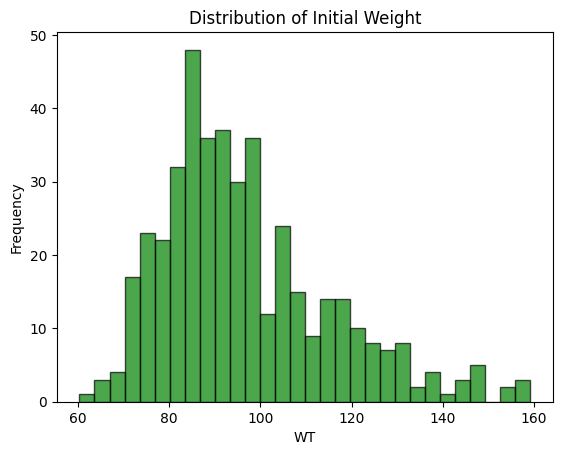

In [5]:
import matplotlib.pyplot as plt

init_weight_dist = summary_df['Initial_WT']
plt.hist(init_weight_dist, bins=30, color='green', edgecolor='black', alpha=0.7)
plt.xlabel("WT")
plt.ylabel("Frequency")
plt.title("Distribution of Initial Weight")

# Display the plot
plt.show()


In [6]:
init_weight_dist = summary_df['Initial_WT']

q1 = np.nanpercentile(init_weight_dist, 25)
q3 = np.nanpercentile(init_weight_dist, 75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Identify outliers
outliers = init_weight_dist[(init_weight_dist < lower_bound) | (init_weight_dist > upper_bound)]

# Count outliers
num_outliers = len(outliers)
num_outliers

14

Text(0.5, 1.0, 'Distribution of ADL Scores at Initial Assessment')

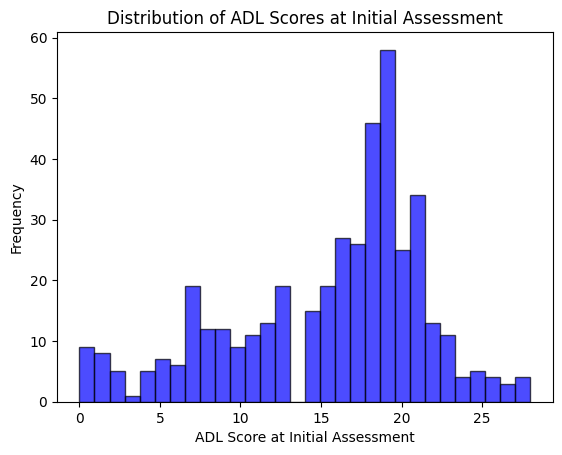

In [7]:
# plot distribution of ADL scores at initial assessment
adl_dist = summary_df['ADL_SCORE_INIT']
plt.hist(adl_dist.dropna(), bins=30, color='blue', edgecolor='black', alpha=0.7)
plt.xlabel("ADL Score at Initial Assessment")
plt.ylabel("Frequency")
plt.title("Distribution of ADL Scores at Initial Assessment")

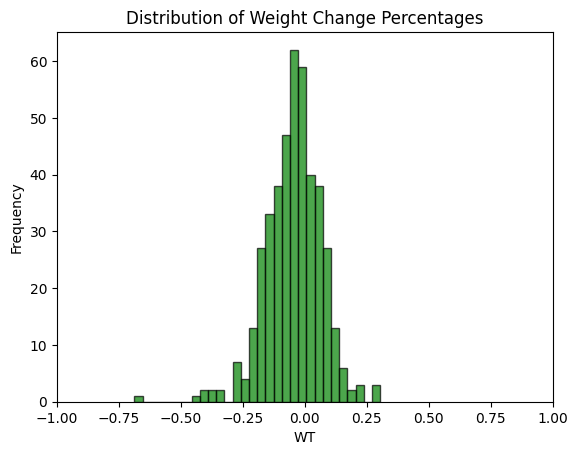

Basic Summary Statistics:
count    430.000000
mean      -0.046176
std        0.112368
min       -0.687805
25%       -0.109804
50%       -0.037634
75%        0.026162
max        0.303665
Name: Overall_WT_Change_Percent, dtype: float64


In [8]:
weight_change_percent_dist = summary_df['Overall_WT_Change_Percent']
plt.hist(weight_change_percent_dist, bins=30, color='green', edgecolor='black', alpha=0.7)
plt.xlabel("WT")
plt.ylabel("Frequency")
plt.title("Distribution of Weight Change Percentages")
plt.xlim(-1, 1)

# Display the plot
plt.show()

summary_stats = weight_change_percent_dist.describe()
print("Basic Summary Statistics:")
print(summary_stats)

In [9]:
dist = summary_df['Overall_WT_Change_Percent'].dropna()

#percentile rank of -10%
percentile_rank = (dist <= -0.10).mean() * 100

print(f"Percentile of -10% weight loss: {percentile_rank:.2f}%")

# explicitly count how many meet the threshold
count_10_loss = (dist <= -0.10).sum()
total = len(dist)

print(f"Residents with ≥10% weight loss: {count_10_loss} out of {total} ({percentile_rank:.2f}%)")

# what threshold corresponds to the 10th percentile (can change to see other percentiles)
ten_percentile_value = np.percentile(dist, 10)
print(f"10th percentile value of Overall WT Change %: {ten_percentile_value:.4f}")

Percentile of -10% weight loss: 27.67%
Residents with ≥10% weight loss: 119 out of 430 (27.67%)
10th percentile value of Overall WT Change %: -0.1764


Summarization of summary dataframe. We see for example that 213 people died before 2 years had passed due to BENE_DEATH_DT having a count of 213

In [10]:
summary_df.describe()

,INITIAL_AGE,BENE_DEATH_DT,First_Assessment,Last_Assessment,Months_Between_Assessments,assessment1_death_month_between,ADL_SCORE_INIT,MOBILITY_SP1_INIT,COG_MS1_INIT,Initial_BMI,Initial_WT,End_WT,Overall_WT_Change,Overall_WT_Change_Percent,ARTHRITIS,STROKE,CANCER,COPD,DIAB,DEMENTIA,DEPRESSION,HEARTFAILURE,HYPERTENSION,ESRD,FT_PROBLEM,HEARING,BOWEL_INCONTINENCE,URINE_INCONTINENCE,ANXTY,MNC_DPRSN,SCHZOPRNIA,PRESSURE_ULCER,MOST_WT_LOSS
count,430.000000,213,430,430,430.000000,213.000000,430.000000,430.000000,387.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.0,430.000000
mean,79.062791,2019-11-22 20:43:56.619718400,2018-02-11 05:18:08.372093184,2019-10-29 23:39:54.418604544,20.518605,21.384977,15.425581,2.174419,1.855297,36.132616,96.572901,91.790143,-4.782758,-0.046176,0.460465,0.202326,0.109302,0.388372,0.579070,0.537209,0.688372,0.606977,0.918605,0.286047,0.995349,0.120930,0.879070,0.934884,0.448837,0.118605,0.120930,0.0,-7.454689
min,66.000000,2018-05-06 00:00:00,2018-01-01 00:00:00,2018-04-18 00:00:00,3.000000,4.000000,0.000000,0.000000,0.000000,30.017906,60.327736,29.029888,-63.956472,-0.687805,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,-70.000000
25%,72.000000,2019-03-08 00:00:00,2018-01-14 06:00:00,2019-08-29 06:00:00,17.250000,12.000000,12.000000,1.000000,2.000000,31.779442,83.460928,78.471416,-10.886208,-0.109804,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.0,-9.079281
50%,78.000000,2019-12-27 00:00:00,2018-02-02 00:00:00,2020-01-31 00:00:00,24.000000,22.000000,17.000000,3.000000,2.000000,34.132300,92.532768,89.130828,-3.628736,-0.037634,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.0,-5.695571
75%,86.000000,2020-08-01 00:00:00,2018-02-26 18:00:00,2020-03-03 18:00:00,25.000000,30.000000,19.000000,3.000000,2.000000,38.266692,105.686936,101.604608,2.267960,0.026162,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.0,-3.418887
max,101.000000,2021-08-11 00:00:00,2019-11-14 00:00:00,2020-03-31 00:00:00,26.000000,43.000000,28.000000,3.000000,3.000000,66.036243,159.210792,181.436800,33.565808,0.303665,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,6.018519
std,8.195642,NaN,NaN,NaN,6.509335,10.180547,6.148724,1.035409,0.878495,5.907094,18.547476,19.370632,11.476840,0.112368,0.499015,0.402202,0.312382,0.487948,0.494283,0.499194,0.463698,0.488991,0.273760,0.452438,0.068120,0.326426,0.326426,0.247018,0.497955,0.323699,0.326426,0.0,7.235939


More analysis of the distribution of Initial Wt and Overall WT Change %

In [11]:
median_value = summary_df['Initial_WT'].median()
Q1 = summary_df['Initial_WT'].quantile(0.25)
Q3 = summary_df['Initial_WT'].quantile(0.75)
IQR = Q3 - Q1

wt_init_stats = [median_value, Q1,Q3,IQR]
wt_init_stats

[np.float64(92.532768),
 np.float64(83.460928),
 np.float64(105.686936),
 np.float64(22.226008000000007)]

In [12]:
median_value = summary_df['Overall_WT_Change'].median()
Q1 = summary_df['Overall_WT_Change'].quantile(0.25)
Q3 = summary_df['Overall_WT_Change'].quantile(0.75)
IQR = Q3 - Q1

wt_change_stats = [median_value, Q1,Q3,IQR]
wt_change_stats

[np.float64(-3.6287359999999893),
 np.float64(-10.886207999999996),
 np.float64(2.267960000000002),
 np.float64(13.154167999999999)]

I made a graph that attempts to visualize overall WT change % to amount of time it took people to die (for those who did). Not pretty, not much of an association

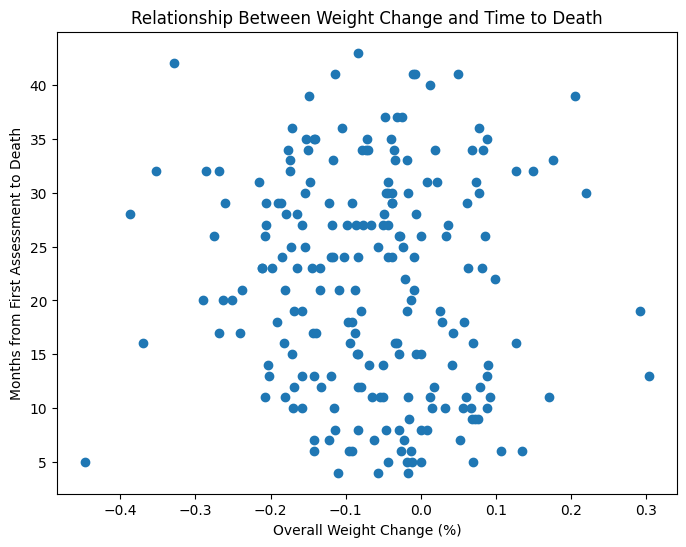

In [13]:
plot_df = summary_df.dropna(subset=["Overall_WT_Change_Percent", "assessment1_death_month_between"])

plt.figure(figsize=(8,6))
plt.scatter(plot_df["Overall_WT_Change_Percent"], plot_df["assessment1_death_month_between"])

plt.xlabel("Overall Weight Change (%)")
plt.ylabel("Months from First Assessment to Death")
plt.title("Relationship Between Weight Change and Time to Death")

plt.show()

Summary of how much each feature correlated with mortality (died/didn't die). Used point-biserial correlation coefficient for numerical cols. All features have a correlation below 0.2 besides age. Might indicate how age is the best single predictor of mortality in this data.

In [14]:
summary_df_copy = summary_df.copy()
summary_df_copy["died"] = summary_df_copy["BENE_DEATH_DT"].notna().astype(int)

illness_cols = [
    'ARTHRITIS','STROKE','CANCER','COPD','DIAB','DEMENTIA','DEPRESSION',
    'HEARTFAILURE','HYPERTENSION','ESRD','FT_PROBLEM','HEARING',
    'BOWEL_INCONTINENCE','URINE_INCONTINENCE','ANXTY','MNC_DPRSN','SCHZOPRNIA'
]

numeric_cols = [
    'INITIAL_AGE', 'ADL_SCORE_INIT', 'MOBILITY_SP1_INIT', 'COG_MS1_INIT',
    'Initial_BMI', 'Overall_WT_Change_Percent', 'Initial_WT'
]

# Keep only columns that actually exist in df
illness_cols = [c for c in illness_cols if c in summary_df_copy.columns]
numeric_cols = [c for c in numeric_cols if c in summary_df_copy.columns]

# Compute correlations
corr_illness = summary_df_copy[illness_cols + ["died"]].corr()["died"].drop("died")
corr_numeric = summary_df_copy[numeric_cols + ["died"]].corr()["died"].drop("died")

corr_illness_df = corr_illness.to_frame(name="Correlation_with_Mortality")
corr_numeric_df = corr_numeric.to_frame(name="Correlation_with_Mortality")

corr_illness_df, corr_numeric_df


(                    Correlation_with_Mortality
 ARTHRITIS                            -0.094057
 STROKE                               -0.058995
 CANCER                                0.129971
 COPD                                  0.107621
 DIAB                                 -0.012642
 DEMENTIA                              0.107973
 DEPRESSION                            0.033912
 HEARTFAILURE                          0.178218
 HYPERTENSION                          0.056767
 ESRD                                  0.165424
 FT_PROBLEM                           -0.068997
 HEARING                               0.060514
 BOWEL_INCONTINENCE                    0.096411
 URINE_INCONTINENCE                    0.054101
 ANXTY                                -0.033688
 MNC_DPRSN                            -0.003781
 SCHZOPRNIA                           -0.139209,
                            Correlation_with_Mortality
 INITIAL_AGE                                  0.253205
 ADL_SCORE_INIT          

Quick attempt to make a logistic regression classifier that took in certain features and tried to predict if a patient died or not.

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

features = [
    'INITIAL_AGE', 'Overall_WT_Change_Percent',
    'ADL_SCORE_INIT',
    'CANCER','COPD','DEMENTIA',
    'HEARTFAILURE','ESRD',
    'BOWEL_INCONTINENCE','SCHZOPRNIA',
]

summary_df_copy = summary_df.copy()
summary_df_copy["died"] = summary_df_copy["BENE_DEATH_DT"].notna().astype(int)

df_model = summary_df_copy[features + ['died']].dropna()

X = df_model[features]
y = df_model['died']

# numeric columns
numeric_features = [col for col in X.columns]

# preprocess data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features)
    ]
)

# create logistic regression pipeline
model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('logreg', LogisticRegression(max_iter=500))
])

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Fit model
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.60      0.63        55
           1       0.62      0.68      0.65        53

    accuracy                           0.64       108
   macro avg       0.64      0.64      0.64       108
weighted avg       0.64      0.64      0.64       108

Confusion Matrix:
[[33 22]
 [17 36]]


Analysis of maximum weight loss going from 1 assessment to the next experienced for all residents, residents who experienced >= 10% weight loss total, and residents who experienced <10% weight loss total. Residents who lost >= 10% weight loss total tended to have higher maximum weight loss values compared to those who only had <10% weight loss total. Note the outlier in the <10% total weight loss group (apparently someone lost 70% of their initial weight but then got it all/nearly all back by their final assessment).

In [16]:

# define the groups
total_residents = len(summary_df)
weight_loss_df = summary_df[summary_df['Overall_WT_Change_Percent'] <= -0.1]
no_weight_loss_df = summary_df[summary_df['Overall_WT_Change_Percent'] > -0.1]

# create descriptive stats tables
dist_all = summary_df['MOST_WT_LOSS'].describe().to_frame(name='All Residents')
dist_weight_loss = weight_loss_df['MOST_WT_LOSS'].describe().to_frame(name='≥10% Weight Loss Group')
dist_no_weight_loss = no_weight_loss_df['MOST_WT_LOSS'].describe().to_frame(name='<10% Weight Loss Group')

print("Distribution of MOST_WT_LOSS - All Residents:")
display(dist_all)

print("\nDistribution of MOST_WT_LOSS - ≥10% Weight Loss Group:")
display(dist_weight_loss)

print("\nDistribution of MOST_WT_LOSS - <10% Weight Loss Group:")
display(dist_no_weight_loss)

Distribution of MOST_WT_LOSS - All Residents:


,All Residents
count,430.000000
mean,-7.454689
std,7.235939
min,-70.000000
25%,-9.079281
50%,-5.695571
75%,-3.418887
max,6.018519



Distribution of MOST_WT_LOSS - ≥10% Weight Loss Group:


,≥10% Weight Loss Group
count,119.000000
mean,-10.289847
std,7.488765
min,-59.512195
25%,-11.583184
50%,-8.484848
75%,-6.184670
max,-2.926829



Distribution of MOST_WT_LOSS - <10% Weight Loss Group:


,<10% Weight Loss Group
count,311.000000
mean,-6.369854
std,6.844296
min,-70.000000
25%,-7.323458
50%,-4.705882
75%,-2.915675
max,6.018519


In [17]:
sum2= summary_df.sort_values("MOST_WT_LOSS", ascending = True)
df_sorted[df_sorted['BENE_ID'].str.contains('JJJJJJJWzz44J4S')]

#person somehow gains 50 kg or ~100 pounds in 3 months, this is physically impossible (probably?)
#not conversion error either

,BENE_ID,DATE_ASSESSMENT,BENE_DEATH_DT,AGE,GENDER,RACE,ADL_SCORE,MOBILITY_SP1,COG_MS1,ARTHRITIS,STROKE,CANCER,COPD,DIAB,DEMENTIA,WT_OLD,BMI,DEPRESSION,HEARTFAILURE,HYPERTENSION,ESRD,FT_PROBLEM,HEARING,BOWEL_INCONTINENCE,URINE_INCONTINENCE,ANXTY,MNC_DPRSN,SCHZOPRNIA,BIMS,PRESSURE_ULCER
30717,JJJJJJJWzz44J4S,2020-02-27,NaT,90,Female,White,19.0,2.0,3.0,NaN,NaN,NaN,NaN,NaN,Dementia,74.842680,32.220833,Depression,NaN,NaN,NaN,Fall history,NaN,NaN,NaN,NaN,NaN,NaN,Severely impaired,NaN
30718,JJJJJJJWzz44J4S,2019-11-28,NaT,89,Female,White,18.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,Dementia,74.842680,32.220833,Depression,NaN,NaN,NaN,Fall history,NaN,Bowel incontinence,Urinary incontinence,NaN,NaN,NaN,Severely impaired,NaN
30719,JJJJJJJWzz44J4S,2019-08-28,NaT,89,Female,White,19.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,Dementia,75.296272,32.416111,Depression,NaN,NaN,NaN,Fall history,NaN,Bowel incontinence,Urinary incontinence,NaN,NaN,NaN,Severely impaired,NaN
30720,JJJJJJJWzz44J4S,2019-05-30,NaT,89,Female,White,18.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,129.273720,55.654167,NaN,NaN,NaN,NaN,Fall history,NaN,Bowel incontinence,Urinary incontinence,NaN,NaN,NaN,Severely impaired,NaN
30721,JJJJJJJWzz44J4S,2019-02-27,NaT,89,Female,White,17.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,Dementia,78.471416,33.783056,Depression,NaN,NaN,NaN,Fall history,NaN,Bowel incontinence,NaN,NaN,NaN,NaN,Severely impaired,NaN
30722,JJJJJJJWzz44J4S,2018-11-29,NaT,88,Female,White,19.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,Dementia,78.925008,33.978333,Depression,NaN,NaN,NaN,Fall history,NaN,Bowel incontinence,NaN,NaN,NaN,NaN,Severely impaired,NaN
30723,JJJJJJJWzz44J4S,2018-08-29,NaT,88,Female,White,17.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,Dementia,79.378600,34.173611,Depression,NaN,NaN,NaN,Fall history,NaN,NaN,NaN,NaN,NaN,NaN,Severely impaired,NaN
30724,JJJJJJJWzz44J4S,2018-05-30,NaT,88,Female,White,17.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN,Dementia,77.110640,33.197222,Depression,NaN,NaN,NaN,Fall history,NaN,Bowel incontinence,NaN,NaN,NaN,NaN,Severely impaired,NaN
30725,JJJJJJJWzz44J4S,2018-05-02,NaT,88,Female,White,18.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN,Dementia,77.110640,33.197222,Depression,NaN,NaN,NaN,Fall history,NaN,NaN,NaN,NaN,NaN,NaN,Severely impaired,NaN
30726,JJJJJJJWzz44J4S,2018-03-15,NaT,88,Female,White,22.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,Dementia,77.110640,33.197222,Depression,NaN,NaN,NaN,Fall history,NaN,NaN,NaN,NaN,NaN,NaN,Severely impaired,NaN


Poor attempt at making a graph that shows the weight trends of every person in the dataset (way too many people to actually do it like this)

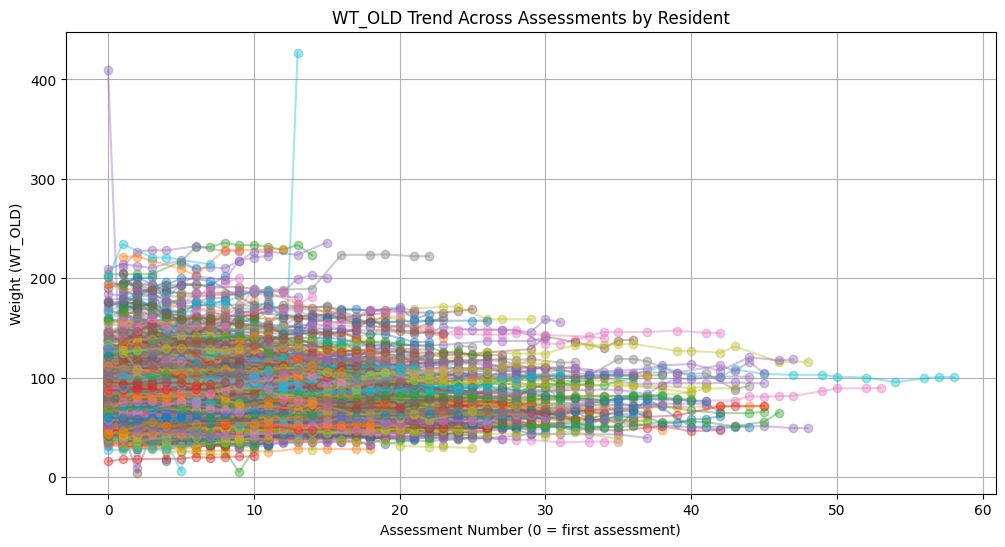

In [18]:
# sort by resident & date
df_sorted = df.sort_values(['BENE_ID', 'DATE_ASSESSMENT'])

# assign assessment index starting at 0 for each resident
df_sorted['ASSESSMENT_NUM'] = df_sorted.groupby('BENE_ID').cumcount()

# keep only patients with at least 2 weight records
plot_df = df_sorted.dropna(subset=['WT_OLD'])

# line plot: one line per resident
plt.figure(figsize=(12, 6))

for bene_id, group in plot_df.groupby('BENE_ID'):
    plt.plot(group['ASSESSMENT_NUM'], group['WT_OLD'], marker='o', alpha=0.4)

plt.title("WT_OLD Trend Across Assessments by Resident")
plt.xlabel("Assessment Number (0 = first assessment)")
plt.ylabel("Weight (WT_OLD)")
plt.grid(True)
plt.show()

Age_Group
65-74   -0.036254
75-84   -0.049283
85-94   -0.056853
95+     -0.026559
Name: Overall_WT_Change_Percent, dtype: float64


/var/folders/0y/mmp_lnms4tx1tvdz0cwsqdx40000gs/T/ipykernel_13730/2380630145.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_means = summary_df.groupby("Age_Group")["Overall_WT_Change_Percent"].mean()


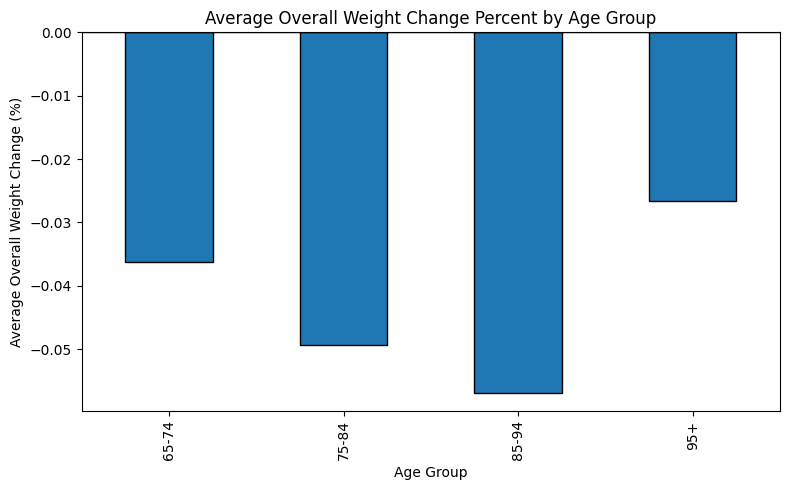

In [19]:
bins = [65, 75, 85, 95, 200]
labels = ["65-74", "75-84", "85-94", "95+"]

summary_df["Age_Group"] = pd.cut(summary_df["INITIAL_AGE"], bins=bins, labels=labels, right=False)

# Compute average weight change by age group
age_group_means = summary_df.groupby("Age_Group")["Overall_WT_Change_Percent"].mean()
print(age_group_means)

plt.figure(figsize=(8,5))
age_group_means.plot(kind="bar", edgecolor="black")
plt.ylabel("Average Overall Weight Change (%)")
plt.xlabel("Age Group")
plt.title("Average Overall Weight Change Percent by Age Group")
plt.axhline(0, color="black", linewidth=1)
plt.tight_layout()
plt.show()

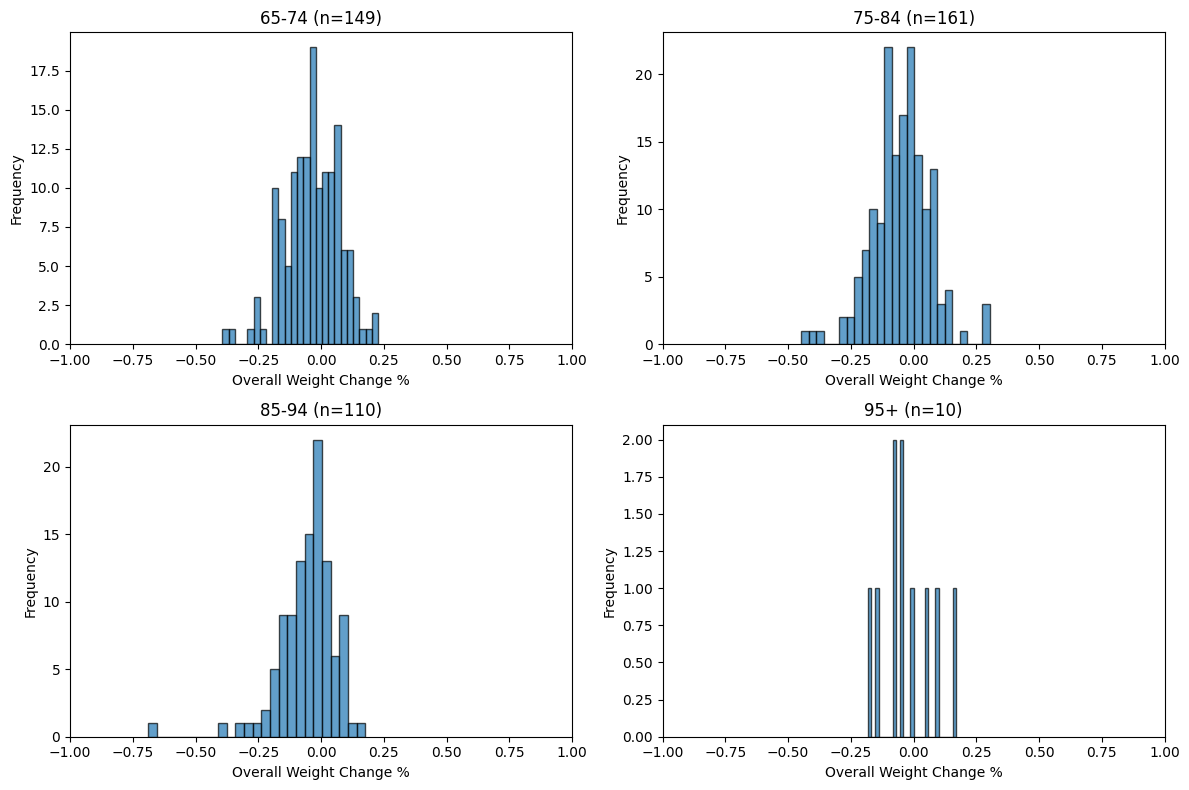

In [20]:
bins = [65, 75, 85, 95, 200]
labels = ["65-74", "75-84", "85-94", "95+"]

summary_df["Age_Group"] = pd.cut(summary_df["INITIAL_AGE"], bins=bins, labels=labels, right=False)
plt.figure(figsize=(12, 8))

for i, group in enumerate(labels):
    group_data = summary_df[summary_df["Age_Group"] == group]["Overall_WT_Change_Percent"].dropna()
    
    plt.subplot(2, 2, i+1)
    plt.hist(group_data, bins=25, edgecolor='black', alpha=0.7)
    plt.title(f"{group} (n={len(group_data)})")
    plt.xlabel("Overall Weight Change %")
    plt.ylabel("Frequency")
    plt.xlim(-1, 1) 

plt.tight_layout()
plt.show()

In [21]:
def correlation_with_ci(df, col, outcome):
    #Return correlation + 95% CI between col and outcome.
    data = df[[col, outcome]].dropna()
    r = data.corr().iloc[0,1]
    n = len(data)

    if n <= 3:
        return pd.Series({"r": r, "CI_lower": np.nan, "CI_upper": np.nan, "n": n})

    # Fisher r-to-z
    z = np.arctanh(r)
    se = 1 / np.sqrt(n - 3)

    z_low = z - 1.96 * se
    z_high = z + 1.96 * se

    # Convert back to r
    r_low = np.tanh(z_low)
    r_high = np.tanh(z_high)

    return pd.Series({"r": r, "CI_lower": r_low, "CI_upper": r_high, "n": n})

results_illness = {}
for col in illness_cols:
    results_illness[col] = correlation_with_ci(summary_df_copy, col, "died")

results_numeric = {}
for col in numeric_cols:
    results_numeric[col] = correlation_with_ci(summary_df_copy, col, "died")

corr_illness_ci_df = pd.DataFrame(results_illness).T
corr_numeric_ci_df = pd.DataFrame(results_numeric).T

corr_illness_ci_df, corr_numeric_ci_df

(                           r  CI_lower  CI_upper      n
 ARTHRITIS          -0.094057 -0.186962  0.000515  430.0
 STROKE             -0.058995 -0.152711  0.035772  430.0
 CANCER              0.129971  0.035844  0.221813  430.0
 COPD                0.107621  0.013187  0.200151  430.0
 DIAB               -0.012642 -0.107082  0.082024  430.0
 DEMENTIA            0.107973  0.013544  0.200493  430.0
 DEPRESSION          0.033912 -0.060851  0.128069  430.0
 HEARTFAILURE        0.178218  0.085084  0.268264  430.0
 HYPERTENSION        0.056767 -0.038004  0.150527  430.0
 ESRD                0.165424  0.071983  0.255987  430.0
 FT_PROBLEM         -0.068997 -0.162505  0.025738  430.0
 HEARING             0.060514 -0.034249  0.154199  430.0
 BOWEL_INCONTINENCE  0.096411  0.001861  0.189254  430.0
 URINE_INCONTINENCE  0.054101 -0.040675  0.147912  430.0
 ANXTY              -0.033688 -0.127849  0.061074  430.0
 MNC_DPRSN          -0.003781 -0.098313  0.090820  430.0
 SCHZOPRNIA         -0.139209 -

In [22]:
summary_df_copy["obesity_class"] = pd.cut(
    summary_df_copy["Initial_BMI"],
    bins=[30, 35, 40, np.inf],
    labels=["Class I", "Class II", "Class III"]
)
stratified_corr = {}

for cls in ["Class I", "Class II", "Class III"]:
    df_cls = summary_df_copy[summary_df_copy["obesity_class"] == cls]

    res_ill = {}
    for col in illness_cols:
        res_ill[col] = correlation_with_ci(df_cls, col, "died")

    res_num = {}
    for col in numeric_cols:
        res_num[col] = correlation_with_ci(df_cls, col, "died")

    stratified_corr[cls] = {
        "illness": pd.DataFrame(res_ill).T,
        "numeric": pd.DataFrame(res_num).T
    }

stratified_corr['Class III']['illness'], stratified_corr['Class III']['numeric']

(                           r  CI_lower  CI_upper     n
 ARTHRITIS          -0.005017 -0.217912  0.208334  85.0
 STROKE             -0.003310 -0.216285  0.209966  85.0
 CANCER              0.169111 -0.045662  0.368942  85.0
 COPD                0.125209 -0.090330  0.329543  85.0
 DIAB               -0.016001 -0.228350  0.197801  85.0
 DEMENTIA            0.141094 -0.074267  0.343881  85.0
 DEPRESSION          0.121112 -0.094453  0.325830  85.0
 HEARTFAILURE        0.082528 -0.132938  0.290546  85.0
 HYPERTENSION       -0.012827 -0.225339  0.200850  85.0
 ESRD                0.019277 -0.194650  0.231454  85.0
 FT_PROBLEM               NaN       NaN       NaN  85.0
 HEARING             0.018363 -0.195530  0.230588  85.0
 BOWEL_INCONTINENCE  0.104071 -0.111531  0.310316  85.0
 URINE_INCONTINENCE -0.012827 -0.225339  0.200850  85.0
 ANXTY              -0.008894 -0.221602  0.204622  85.0
 MNC_DPRSN          -0.009930 -0.222587  0.203629  85.0
 SCHZOPRNIA         -0.116384 -0.321536  0.09920

In [23]:
died_df = summary_df_copy[summary_df_copy["died"] == 1]
alive_df = summary_df_copy[summary_df_copy["died"] == 0]

excessive_loss_df = summary_df_copy[summary_df_copy["Overall_WT_Change_Percent"] <= -0.10]
no_excessive_loss_df = summary_df_copy[summary_df_copy["Overall_WT_Change_Percent"] > -0.10]

def comorbidity_profile(group_df, illness_cols):
    #Return prevalence (percentage) of each condition in group_df
    profile = {}
    n = len(group_df)

    for cond in illness_cols:
        if cond in group_df.columns:
            prevalence = group_df[cond].mean() * 100
            profile[cond] = round(prevalence, 1)

    return pd.Series(profile)

mortality_profiles = pd.DataFrame({
    "Died_%": comorbidity_profile(died_df, illness_cols),
    "Survived_%": comorbidity_profile(alive_df, illness_cols)
})
mortality_profiles

,Died_%,Survived_%
ARTHRITIS,41.3,50.7
STROKE,17.8,22.6
CANCER,15.0,6.9
COPD,44.1,33.6
DIAB,57.3,58.5
DEMENTIA,59.2,48.4
DEPRESSION,70.4,67.3
HEARTFAILURE,69.5,52.1
HYPERTENSION,93.4,90.3
ESRD,36.2,21.2


In [24]:
excessive_loss_profiles = pd.DataFrame({
    "ExcessiveLoss_%": comorbidity_profile(excessive_loss_df, illness_cols),
    "NoExcessiveLoss_%": comorbidity_profile(no_excessive_loss_df, illness_cols)
})
excessive_loss_profiles

,ExcessiveLoss_%,NoExcessiveLoss_%
ARTHRITIS,44.5,46.6
STROKE,22.7,19.3
CANCER,16.0,9.0
COPD,39.5,38.6
DIAB,66.4,54.7
DEMENTIA,60.5,51.1
DEPRESSION,76.5,65.9
HEARTFAILURE,67.2,58.2
HYPERTENSION,95.0,90.7
ESRD,38.7,24.8


ANOVA testing for:\
Overall Weight-Change% Across BMI Obesity Classes, this tests whether obesity class is associated with different mean weight-change percentages.\
Weight-Change% by Mortality Status, this tests whether mortality is associated with different mean weight-change percentages.\
Weight-Change% Across Cognitive Status Levels, this tests whether cognitive impairment level predicts degree of weight loss.\

Results showed that:\
Weight-loss % differs significantly by obesity class (0.0065 pval)\
Strong evidence: those who die lose more weight (0.00031 pval)\
No meaningful differences in weight-loss % (0.109 pval)\


In [25]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

df = summary_df.copy()
def assign_obesity_class(bmi):
    if bmi >= 40:
        return "Class III"
    elif bmi >= 35:
        return "Class II"
    elif bmi >= 30:
        return "Class I"
    else:
        return "Non-obese"

df["Obesity_Class"] = df["Initial_BMI"].apply(assign_obesity_class)

# Keep only obese classes for ANOVA
df_obese = df[df["Obesity_Class"].isin(["Class I", "Class II", "Class III"])].copy()

# ANOVA model
model_obesity = ols("Overall_WT_Change_Percent ~ C(Obesity_Class)", data=df_obese).fit()
anova_results_obesity = sm.stats.anova_lm(model_obesity, typ=2)


# 2. MORTALITY STATUS ANOVA

df["died"] = df["BENE_DEATH_DT"].notna().astype(int)
model_mortality = ols("Overall_WT_Change_Percent ~ C(died)", data=df).fit()
anova_results_mortality = sm.stats.anova_lm(model_mortality, typ=2)


# 3. COGNITIVE STATUS ANOVA

# Clean cognitive categories
valid_cog = [
    "Cognitively intact",
    "Mildly impaired",
    "Moderately impaired",
    "Severely impaired"
]

df_cog = df[df["Initial_BIMS"].isin(valid_cog)]

model_cognition = ols("Overall_WT_Change_Percent ~ C(Initial_BIMS)", data=df_cog).fit()
anova_results_cognition = sm.stats.anova_lm(model_cognition, typ=2)


# PRINT RESULTS

print("\n=== ANOVA: Weight Change % Across Obesity Classes ===")
print(anova_results_obesity)

print("\n=== ANOVA: Weight Change % by Mortality Status ===")
print(anova_results_mortality)

print("\n=== ANOVA: Weight Change % Across Cognitive Status ===")
print(anova_results_cognition)


=== ANOVA: Weight Change % Across Obesity Classes ===
                    sum_sq     df         F    PR(>F)
C(Obesity_Class)  0.126185    2.0  5.092146  0.006523
Residual          5.290610  427.0       NaN       NaN

=== ANOVA: Weight Change % by Mortality Status ===
            sum_sq     df          F    PR(>F)
C(died)   0.162444    1.0  13.232077  0.000309
Residual  5.254351  428.0        NaN       NaN

=== ANOVA: Weight Change % Across Cognitive Status ===
                   sum_sq     df         F    PR(>F)
C(Initial_BIMS)  0.076144    3.0  2.029126  0.109191
Residual         5.166031  413.0       NaN       NaN


# Creation of Figures and Tables #

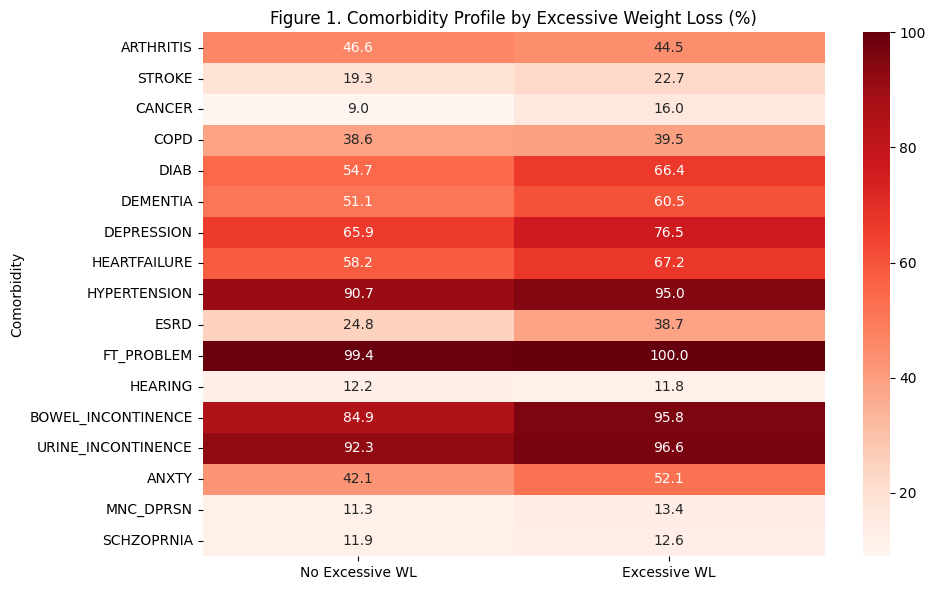

In [26]:
import seaborn as sns
# Excessive weight loss indicator
summary_df2 = summary_df.copy()
summary_df2['Excessive_WL'] = (summary_df['Overall_WT_Change_Percent'] <= -0.10).astype(int)

# Mortality indicator
summary_df2['died'] = summary_df['BENE_DEATH_DT'].notna().astype(int)

# Obesity class
bmi_bins = [30, 35, 40, np.inf]
bmi_labels = ['Class I', 'Class II', 'Class III']
summary_df2['Obesity_Class'] = pd.cut(
    summary_df2['Initial_BMI'],
    bins=bmi_bins,
    labels=bmi_labels
)

illness_cols = [
    'ARTHRITIS','STROKE','CANCER','COPD','DIAB','DEMENTIA',
    'DEPRESSION','HEARTFAILURE','HYPERTENSION','ESRD',
    'FT_PROBLEM','HEARING','BOWEL_INCONTINENCE',
    'URINE_INCONTINENCE','ANXTY','MNC_DPRSN','SCHZOPRNIA'
]

heatmap_df = (
    summary_df2
    .groupby('Excessive_WL')[illness_cols]
    .mean()
    .rename(index={0: 'No Excessive WL', 1: 'Excessive WL'})
)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_df.T * 100, annot=True, fmt=".1f", cmap="Reds")
plt.title("Figure 1. Comorbidity Profile by Excessive Weight Loss (%)")
plt.xlabel("")
plt.ylabel("Comorbidity")
plt.tight_layout()
plt.show()



/var/folders/0y/mmp_lnms4tx1tvdz0cwsqdx40000gs/T/ipykernel_13730/2664212954.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('Obesity_Class')[illness_cols]


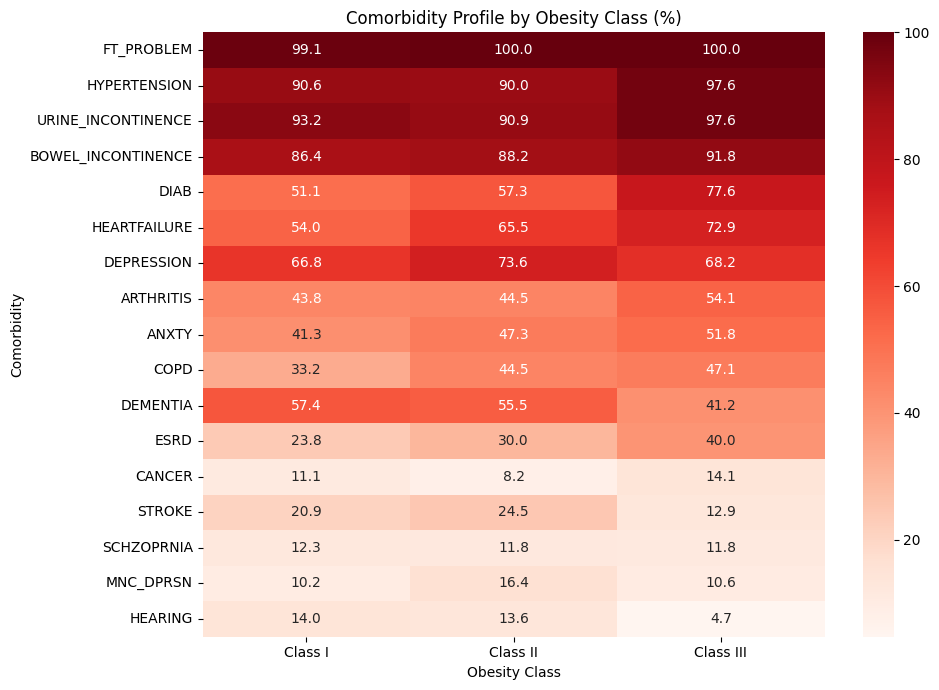

In [27]:
# Keep only obesity classes (non-null)
hm_subset = summary_df2.loc[summary_df2['Obesity_Class'].notna()].copy()

# Make ordering explicit (important for heatmap row order)
hm_subset['Obesity_Class'] = pd.Categorical(
    hm_subset['Obesity_Class'],
    categories=['Class I', 'Class II', 'Class III'],
    ordered=True
)

heatmap_ob_df = (
    hm_subset
    .groupby('Obesity_Class')[illness_cols]
    .mean()
    .T
)

heatmap_ob_df = heatmap_ob_df.sort_values(by='Class III', ascending=False)

plt.figure(figsize=(10, 7))
sns.heatmap(
    heatmap_ob_df * 100,
    annot=True,
    fmt=".1f",
    cmap="Reds"
)
plt.title("Comorbidity Profile by Obesity Class (%)")
plt.xlabel("Obesity Class")
plt.ylabel("Comorbidity")
plt.tight_layout()
plt.show()

In [28]:
subset = summary_df2[
    (summary_df2['Excessive_WL'] == 1) &
    (summary_df2['Obesity_Class'].notna())
]

mortality_comorbidity = (
    subset
    .groupby('died')[illness_cols]
    .mean()
    .rename(index={0: 'Survived', 1: 'Died'})
    .T
)

mortality_comorbidity['Difference_%'] = (
    mortality_comorbidity['Died'] - mortality_comorbidity['Survived']
) * 100

mortality_comorbidity = mortality_comorbidity.sort_values(
    'Difference_%', ascending=False
)

mortality_comorbidity



died,Survived,Died,Difference_%
ESRD,0.225,0.468354,24.335443
DEMENTIA,0.500,0.658228,15.822785
HEARTFAILURE,0.575,0.721519,14.651899
COPD,0.325,0.430380,10.537975
DIAB,0.600,0.696203,9.620253
CANCER,0.100,0.189873,8.987342
HYPERTENSION,0.925,0.962025,3.702532
HEARING,0.100,0.126582,2.658228
MNC_DPRSN,0.125,0.139241,1.424051
BOWEL_INCONTINENCE,0.950,0.962025,1.202532


In [29]:
from scipy.stats import pearsonr

# obese + excessive WL
subset = summary_df2[
    (summary_df2['Excessive_WL'] == 1) &
    (summary_df2['Obesity_Class'].notna())
].copy()

# Build ADL category indicators
subset['ADL_SCORE_INIT'] = pd.to_numeric(subset['ADL_SCORE_INIT'], errors='coerce')

subset['ADL_Impairment'] = pd.cut(
    subset['ADL_SCORE_INIT'],
    bins=[-np.inf, 12, 20, np.inf],
    labels=['Mild (0-12)', 'Moderate (13-20)', 'Severe (21-28)'] 
)

adl_levels = ['Mild (0-12)', 'Moderate (13-20)', 'Severe (21-28)']
for lvl in adl_levels:
    subset[f'ADL: {lvl}'] = (subset['ADL_Impairment'] == lvl).astype(int)

adl_indicator_cols = [f'ADL: {lvl}' for lvl in adl_levels]

# Build BIMS category indicators
# BIMS is already text categories
bims_levels = ["Cognitively intact", "Mildly impaired", "Moderately impaired", "Severely impaired"]
for lvl in bims_levels:
    subset[f'BIMS: {lvl}'] = (subset['Initial_BIMS'] == lvl).astype(int)

bims_indicator_cols = [f'BIMS: {lvl}' for lvl in bims_levels]

# Final variable list
vars_for_table = illness_cols + adl_indicator_cols + bims_indicator_cols

# (Optional but nice) keep ordering: comorbidities, then ADL, then BIMS
ordered_rows = illness_cols + adl_indicator_cols + bims_indicator_cols

# Mean by mortality group
mortality_tbl = (
    subset.groupby('died')[vars_for_table]
          .mean(numeric_only=True)
          .rename(index={0: 'Survived', 1: 'Died'})
          .T
)

# Ensure both columns exist even if one group is missing (rare but possible)
for col in ['Survived', 'Died']:
    if col not in mortality_tbl.columns:
        mortality_tbl[col] = np.nan

# Difference in percentage points (all rows are indicators now)
mortality_tbl['Difference_%'] = (mortality_tbl['Died'] - mortality_tbl['Survived']) * 100

# Correlation + p-value vs mortality
corrs, pvals = [], []
y = subset['died'].astype(float).values

for v in vars_for_table:
    x = pd.to_numeric(subset[v], errors='coerce').values
    mask = np.isfinite(x) & np.isfinite(y)

    if mask.sum() < 3 or np.nanstd(x[mask]) == 0:
        corrs.append(np.nan)
        pvals.append(np.nan)
    else:
        r, p = pearsonr(x[mask], y[mask])  # phi coefficient for binary-binary
        corrs.append(r)
        pvals.append(p)

mortality_tbl['Correlation_r'] = corrs
mortality_tbl['p_value'] = pvals

mortality_tbl['Survived_%'] = (mortality_tbl['Survived'] * 100).round(1)
mortality_tbl['Died_%'] = (mortality_tbl['Died'] * 100).round(1)
mortality_tbl['Difference_pp'] = mortality_tbl['Difference_%'].round(1)

# Reorder rows (optional)
mortality_tbl = mortality_tbl.reindex(ordered_rows)

# Sort within table: by absolute difference in percentage points (optional)
mortality_tbl = mortality_tbl.sort_values('Difference_%', key=lambda s: s.abs(), ascending=False)

# Final columns to show
final_cols = ['Survived_%', 'Died_%', 'Difference_pp', 'Correlation_r', 'p_value']

mortality_tbl[final_cols].sort_values(by='p_value')

died,Survived_%,Died_%,Difference_pp,Correlation_r,p_value
ESRD,22.5,46.8,24.3,0.236071,0.009747
ADL: Moderate (13-20),47.5,70.9,23.4,0.228846,0.012301
ADL: Mild (0-12),25.0,11.4,-13.6,-0.175488,0.056264
SCHZOPRNIA,20.0,8.9,-11.1,-0.158539,0.085049
DEMENTIA,50.0,65.8,15.8,0.152901,0.096889
HEARTFAILURE,57.5,72.2,14.7,0.147455,0.109526
STROKE,30.0,19.0,-11.0,-0.124211,0.178336
CANCER,10.0,19.0,9.0,0.115904,0.209387
BIMS: Moderately impaired,27.5,17.7,-9.8,-0.113392,0.219498
ADL: Severe (21-28),27.5,17.7,-9.8,-0.113392,0.219498


In [38]:
import statsmodels.formula.api as smf

summary_df2 = summary_df2.copy()

summary_df2['INITIAL_AGE'] = pd.to_numeric(summary_df2['INITIAL_AGE'], errors='coerce')
summary_df2['ADL_SCORE_INIT'] = pd.to_numeric(summary_df2['ADL_SCORE_INIT'], errors='coerce')
summary_df2['Initial_BMI'] = pd.to_numeric(summary_df2['Initial_BMI'], errors='coerce')

# Comorbidities should already be 0/1 ints, but keep this safe:
summary_df2[illness_cols] = summary_df2[illness_cols].apply(pd.to_numeric, errors='coerce')

# Build categorical variables with requested baselines

# Obesity class baseline: Class I (assumes you already created Obesity_Class earlier)
summary_df2['Obesity_Class'] = pd.Categorical(
    summary_df2['Obesity_Class'],
    categories=['Class I', 'Class II', 'Class III'],
    ordered=True
)

# Age groups baseline: 65–74
# IMPORTANT: removed "<65" group completely (cleaned dataset has none; it caused singularity)
summary_df2['Age_Group'] = pd.cut(
    summary_df2['INITIAL_AGE'],
    bins=[64, 74, 84, 94, np.inf],
    labels=['65-74', '75-84', '85-94', '95+'],
    include_lowest=True
).astype('category')

# ADL impairment baseline: Mild (0–12)
summary_df2['ADL_Impairment'] = pd.cut(
    summary_df2['ADL_SCORE_INIT'],
    bins=[-np.inf, 12, 20, np.inf],
    labels=['Mild (0-12)', 'Moderate (13-20)', 'Severe (21+)']
)
summary_df2['ADL_Impairment'] = pd.Categorical(
    summary_df2['ADL_Impairment'],
    categories=['Mild (0-12)', 'Moderate (13-20)', 'Severe (21+)'],
    ordered=True
)

# Cognitive baseline: Cognitively intact
# Your Initial_BIMS is text: "Cognitively intact", "Mildly impaired", "Moderately impaired", "Severely impaired"
# Combine Mildly + Moderately => "Moderate impairment" to match your baseline list
cog_map = {
    "Cognitively intact": "Cognitively intact",
    "Mildly impaired": "Moderate impairment",
    "Moderately impaired": "Moderate impairment",
    "Severely impaired": "Severe impairment"
}
summary_df2['Cognitive_Status'] = summary_df2['Initial_BIMS'].map(cog_map)

summary_df2['Cognitive_Status'] = pd.Categorical(
    summary_df2['Cognitive_Status'],
    categories=['Cognitively intact', 'Moderate impairment', 'Severe impairment'],
    ordered=True
)

# Ensure these are categories for formula handling
summary_df2['GENDER'] = summary_df2['GENDER'].astype('category')
summary_df2['RACE'] = summary_df2['RACE'].astype('category')

# Build modeling dataset
model_cols = (
    ['died', 'Excessive_WL', 'Obesity_Class', 'Age_Group', 'GENDER', 'RACE',
     'ADL_Impairment', 'Cognitive_Status']
    + illness_cols
)

dfm = summary_df2[model_cols].dropna().copy()

# Drop any constant disease columns within dfm (extra safety)
const_cols = [c for c in illness_cols if dfm[c].nunique(dropna=False) <= 1]
illness_cols_final = [c for c in illness_cols if c not in const_cols]

print("Rows used in model:", dfm.shape[0])
print("Deaths / Survivors:", dfm['died'].value_counts().to_dict())
print("Dropped constant comorbidity cols (if any):", const_cols)

# Fit logistic regression
disease_terms = " + ".join(illness_cols_final)

formula = f"""
died ~ Excessive_WL
     + C(Obesity_Class, Treatment(reference='Class I'))
     + C(Age_Group, Treatment(reference='65-74'))
     + C(GENDER, Treatment(reference='Male'))
     + C(RACE, Treatment(reference='White'))
     + C(ADL_Impairment, Treatment(reference='Mild (0-12)'))
     + C(Cognitive_Status, Treatment(reference='Cognitively intact'))
     + {disease_terms}
"""

logit_model = smf.logit(formula=formula, data=dfm).fit(method="lbfgs", maxiter=500, disp=True)
print(logit_model.summary())

# Odds ratios + 95% CI + p-values table
params = logit_model.params
conf = logit_model.conf_int()
or_table = pd.DataFrame({
    "OR": np.exp(params),
    "CI_lower": np.exp(conf[0]),
    "CI_upper": np.exp(conf[1]),
    "p_value": logit_model.pvalues
}).sort_values("p_value")

or_table
logit_model.summary()

Rows used in model: 417
Deaths / Survivors: {0: 211, 1: 206}
Dropped constant comorbidity cols (if any): []
                           Logit Regression Results                           
Dep. Variable:                   died   No. Observations:                  417
Model:                          Logit   Df Residuals:                      384
Method:                           MLE   Df Model:                           32
Date:                Thu, 12 Feb 2026   Pseudo R-squ.:                  0.1943
Time:                        20:00:46   Log-Likelihood:                -232.85
converged:                       True   LL-Null:                       -289.01
Covariance Type:            nonrobust   LLR p-value:                 7.327e-11
                                                                                            coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------

/Users/Thebigkab00m/miniforge3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   died   No. Observations:                  417
Model:                          Logit   Df Residuals:                      384
Method:                           MLE   Df Model:                           32
Date:                Thu, 12 Feb 2026   Pseudo R-squ.:                  0.1943
Time:                        20:00:46   Log-Likelihood:                -232.85
converged:                       True   LL-Null:                       -289.01
Covariance Type:            nonrobust   LLR p-value:                 7.327e-11
=========================================================================================================================================================
                                                                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                 9.5613    390.906      0.024      0.980    -756.601     775.723
C(Obesity_Class, Treatment(reference='Class I'))[T.Class II]                             -0.0696      0.278     -0.250      0.802      -0.615       0.476
C(Obesity_Class, Treatment(reference='Class I'))[T.Class III]                            -0.2975      0.319     -0.932      0.351      -0.923       0.328
C(Age_Group, Treatment(reference='65-74'))[T.75-84]                                       0.6967      0.275      2.535      0.011       0.158       1.235
C(Age_Group, Treatment(reference='65-74'))[T.85-94]                                       1.1789      0.342      3.444      0.001       0.508       1.850
C(Age_Group, Treatment(reference='65-74'))[T.95+]                                         3.1799      1.270      2.503      0.012       0.690       5.670
C(GENDER, Treatment(reference='Male'))[T.Female]                                         -0.6865      0.264     -2.599      0.009      -1.204      -0.169
C(RACE, Treatment(reference='White'))[T.Asian]                                            0.0007      1.530      0.000      1.000      -2.998       2.999
C(RACE, Treatment(reference='White'))[T.Black]                                           -0.3240      0.325     -0.997      0.319      -0.961       0.313
C(RACE, Treatment(reference='White'))[T.Hispanic]                                        -0.4051      0.515     -0.787      0.432      -1.414       0.604
C(RACE, Treatment(reference='White'))[T.Missing]                                         -0.6115      0.974     -0.628      0.530      -2.521       1.298
C(ADL_Impairment, Treatment(reference='Mild (0-12)'))[T.Moderate (13-20)]                 0.3131      0.299      1.046      0.296      -0.274       0.900
C(ADL_Impairment, Treatment(reference='Mild (0-12)'))[T.Severe (21+)]                     0.6301      0.385      1.635      0.102      -0.125       1.385
C(Cognitive_Status, Treatment(reference='Cognitively intact'))[T.Moderate impairment]     0.3008      0.276      1.088      0.277      -0.241       0.843
C(Cognitive_Status, Treatment(reference='Cognitively intact'))[T.Severe impairment]       0.6168      0.368      1.674      0.094      -0.105       1.339
Excessive_WL                                                                              0.8448      0.270      3.132      0.002       0.316       1.373
ARTHRITIS                                                                                -0.6676      0.242     -2.755      0.006      -1.143      -0.193
STROKE                                                                                   -0.3491      0.307     -1.139      0.255      -0.950       0.252
CANCER 

# Requested Summary Table

In [33]:
def final_create_sumtable(df):
    # Create a copy to avoid modifying the original dataframe
    df = df.copy()
    
    # Define groups
    all_sample = df
    excessive_wl = df[df['Overall_WT_Change_Percent'] <= -0.1]
    no_excessive_wl = df[df['Overall_WT_Change_Percent'] > -0.1]
    
    # Get group sizes
    n_all = len(all_sample)
    n_excessive = len(excessive_wl)
    n_no_excessive = len(no_excessive_wl)
    
    # Helper functions
    def format_n_pct(n, total):
        pct = (n / total * 100) if total > 0 else 0
        return f"{n} ({pct:.1f}%)"
    
    def format_mean_sd(series):
        return f"{series.mean():.1f} ({series.std():.1f})"
    
    def get_category_stats(category_name, all_count, exc_count, no_exc_count):
        return {
            'Category': category_name,
            'All sample': format_n_pct(all_count, n_all),
            'Excessive Weight Loss': format_n_pct(exc_count, n_excessive),
            'No Excessive Weight Loss': format_n_pct(no_exc_count, n_no_excessive)
        }
    
    # Initialize table
    rows = []
    
    # Header row with sample sizes
    rows.append({
        'Category': 'Total N',
        'All sample': f"{n_all} (100%)",
        'Excessive Weight Loss': f"{n_excessive} ({n_excessive/n_all*100:.1f}%)",
        'No Excessive Weight Loss': f"{n_no_excessive} ({n_no_excessive/n_all*100:.1f}%)"
    })
    
    # Mortality
    n_all_mort = all_sample['BENE_DEATH_DT'].notna().sum()
    n_exc_mort = excessive_wl['BENE_DEATH_DT'].notna().sum()
    n_no_exc_mort = no_excessive_wl['BENE_DEATH_DT'].notna().sum()
    rows.append(get_category_stats('Mortality', n_all_mort, n_exc_mort, n_no_exc_mort))
    
    # Obesity Classes
    rows.append({'Category': 'Obesity Class', 'All sample': '', 'Excessive Weight Loss': '', 'No Excessive Weight Loss': ''})
    
    obesity_bins = [30, 35, 40, np.inf]
    obesity_labels = ['Class I', 'Class II', 'Class III']
    all_sample['obesity_class'] = pd.cut(all_sample['Initial_BMI'], bins=obesity_bins, labels=obesity_labels)
    excessive_wl['obesity_class'] = pd.cut(excessive_wl['Initial_BMI'], bins=obesity_bins, labels=obesity_labels)
    no_excessive_wl['obesity_class'] = pd.cut(no_excessive_wl['Initial_BMI'], bins=obesity_bins, labels=obesity_labels)
    
    for obesity_class in obesity_labels:
        n_all_ob = (all_sample['obesity_class'] == obesity_class).sum()
        n_exc_ob = (excessive_wl['obesity_class'] == obesity_class).sum()
        n_no_exc_ob = (no_excessive_wl['obesity_class'] == obesity_class).sum()
        rows.append(get_category_stats(f'  {obesity_class}', n_all_ob, n_exc_ob, n_no_exc_ob))
    
    # Weight loss metrics (mean ± SD)
    rows.append({
        'Category': 'Overall Weight Change %, mean (SD)',
        'All sample': format_mean_sd(all_sample['Overall_WT_Change_Percent'] * 100),
        'Excessive Weight Loss': format_mean_sd(excessive_wl['Overall_WT_Change_Percent'] * 100),
        'No Excessive Weight Loss': format_mean_sd(no_excessive_wl['Overall_WT_Change_Percent'] * 100)
    })
    
    # Demographics section
    rows.append({'Category': 'Demographics', 'All sample': '', 'Excessive Weight Loss': '', 'No Excessive Weight Loss': ''})
    
    # Age mean (SD)
    rows.append({
        'Category': 'Age, mean (SD)',
        'All sample': format_mean_sd(all_sample['INITIAL_AGE']),
        'Excessive Weight Loss': format_mean_sd(excessive_wl['INITIAL_AGE']),
        'No Excessive Weight Loss': format_mean_sd(no_excessive_wl['INITIAL_AGE'])
    })
    
    # Age categories
    age_bins = [64, 74, 84, 94, 120]
    age_labels = ['65-74', '75-84', '85-94', '≥95']
    all_sample['age_group'] = pd.cut(all_sample['INITIAL_AGE'], bins=age_bins, labels=age_labels)
    excessive_wl['age_group'] = pd.cut(excessive_wl['INITIAL_AGE'], bins=age_bins, labels=age_labels)
    no_excessive_wl['age_group'] = pd.cut(no_excessive_wl['INITIAL_AGE'], bins=age_bins, labels=age_labels)
    
    for age_group in age_labels:
        n_all_age = (all_sample['age_group'] == age_group).sum()
        n_exc_age = (excessive_wl['age_group'] == age_group).sum()
        n_no_exc_age = (no_excessive_wl['age_group'] == age_group).sum()
        rows.append(get_category_stats(f'  {age_group}', n_all_age, n_exc_age, n_no_exc_age))
    
    # Gender
    rows.append({'Category': 'Gender', 'All sample': '', 'Excessive Weight Loss': '', 'No Excessive Weight Loss': ''})
    for gender in ['Female', 'Male']:
        n_all_gen = (all_sample['GENDER'] == gender).sum()
        n_exc_gen = (excessive_wl['GENDER'] == gender).sum()
        n_no_exc_gen = (no_excessive_wl['GENDER'] == gender).sum()
        rows.append(get_category_stats(f'  {gender}', n_all_gen, n_exc_gen, n_no_exc_gen))
    
    # Racial/ethnicity
    rows.append({'Category': 'Racial/Ethnicity', 'All sample': '', 'Excessive Weight Loss': '', 'No Excessive Weight Loss': ''})
    
    n_all_white = (all_sample['RACE'] == 'White').sum()
    n_exc_white = (excessive_wl['RACE'] == 'White').sum()
    n_no_exc_white = (no_excessive_wl['RACE'] == 'White').sum()
    rows.append(get_category_stats('  White', n_all_white, n_exc_white, n_no_exc_white))
    
    n_all_black = (all_sample['RACE'] == 'Black').sum()
    n_exc_black = (excessive_wl['RACE'] == 'Black').sum()
    n_no_exc_black = (no_excessive_wl['RACE'] == 'Black').sum()
    rows.append(get_category_stats('  Black', n_all_black, n_exc_black, n_no_exc_black))
    
    n_all_hisp = (all_sample['RACE'] == 'Hispanic').sum()
    n_exc_hisp = (excessive_wl['RACE'] == 'Hispanic').sum()
    n_no_exc_hisp = (no_excessive_wl['RACE'] == 'Hispanic').sum()
    rows.append(get_category_stats('  Hispanic', n_all_hisp, n_exc_hisp, n_no_exc_hisp))
    
    n_all_other = (~all_sample['RACE'].isin(['White', 'Black', 'Hispanic'])).sum()
    n_exc_other = (~excessive_wl['RACE'].isin(['White', 'Black', 'Hispanic'])).sum()
    n_no_exc_other = (~no_excessive_wl['RACE'].isin(['White', 'Black', 'Hispanic'])).sum()
    rows.append(get_category_stats('  Other', n_all_other, n_exc_other, n_no_exc_other))
    
    # Functional Status
    rows.append({'Category': 'Functional Status', 'All sample': '', 'Excessive Weight Loss': '', 'No Excessive Weight Loss': ''})
    
    # ADL categories
    adl_bins = [0, 12, 20, 28]
    adl_labels = ['Mild (0-12)', 'Moderate (13-20)', 'Severe (21-28)']
    all_sample['adl_category'] = pd.cut(all_sample['ADL_SCORE_INIT'], bins=adl_bins, labels=adl_labels)
    excessive_wl['adl_category'] = pd.cut(excessive_wl['ADL_SCORE_INIT'], bins=adl_bins, labels=adl_labels)
    no_excessive_wl['adl_category'] = pd.cut(no_excessive_wl['ADL_SCORE_INIT'], bins=adl_bins, labels=adl_labels)
    
    rows.append({'Category': '  ADL Impairment', 'All sample': '', 'Excessive Weight Loss': '', 'No Excessive Weight Loss': ''})
    for adl_cat in adl_labels:
        n_all_adl = (all_sample['adl_category'] == adl_cat).sum()
        n_exc_adl = (excessive_wl['adl_category'] == adl_cat).sum()
        n_no_exc_adl = (no_excessive_wl['adl_category'] == adl_cat).sum()
        rows.append(get_category_stats(f'    {adl_cat}', n_all_adl, n_exc_adl, n_no_exc_adl))
    
    # Cognitive Impairment
    rows.append({'Category': '  Cognitive Impairment', 'All sample': '', 'Excessive Weight Loss': '', 'No Excessive Weight Loss': ''})
    cog_categories = ['Cognitively intact', 'Mildly impaired', 'Moderately impaired', 'Severely impaired']
    for cog_cat in cog_categories:
        n_all_cog = (all_sample['Initial_BIMS'] == cog_cat).sum()
        n_exc_cog = (excessive_wl['Initial_BIMS'] == cog_cat).sum()
        n_no_exc_cog = (no_excessive_wl['Initial_BIMS'] == cog_cat).sum()
        rows.append(get_category_stats(f'    {cog_cat}', n_all_cog, n_exc_cog, n_no_exc_cog))
    
    # Comorbidities
    rows.append({'Category': 'Comorbidities', 'All sample': '', 'Excessive Weight Loss': '', 'No Excessive Weight Loss': ''})
    
    comorbidities = [
        ('Arthritis', 'ARTHRITIS'),
        ('Stroke', 'STROKE'),
        ('Cancer', 'CANCER'),
        ('COPD', 'COPD'),
        ('Diabetes', 'DIAB'),
        ('Dementia', 'DEMENTIA'),
        ('Depression', 'DEPRESSION'),
        ('Heart Failure', 'HEARTFAILURE'),
        ('Hypertension', 'HYPERTENSION'),
        ('End-Stage Renal Disease', 'ESRD'),
        ('Fall History', 'FT_PROBLEM'),
        ('Hearing Impairment', 'HEARING'),
        ('Bowel Incontinence', 'BOWEL_INCONTINENCE'),
        ('Urinary Incontinence', 'URINE_INCONTINENCE'),
        ('Anxiety', 'ANXTY'),
        ('Manic Depression', 'MNC_DPRSN'),
        ('Schizophrenia', 'SCHZOPRNIA')
    ]
    
    for label, col in comorbidities:
        if col in df.columns:
            n_all_comorb = (all_sample[col] == 1).sum()
            n_exc_comorb = (excessive_wl[col] == 1).sum()
            n_no_exc_comorb = (no_excessive_wl[col] == 1).sum()
            rows.append(get_category_stats(f'  {label}', n_all_comorb, n_exc_comorb, n_no_exc_comorb))
    
    # Create DataFrame
    table1 = pd.DataFrame(rows)
    
    return table1

# Create the table
table1 = final_create_sumtable(summary_df)

# Display the table
print("\nTable 1. Summary Statistics")
print("=" * 100)
display(table1)

# Save to CSV (if needed)
# table1.to_csv('final_summary_statistics.csv', index=False)
# print("\nTable saved to 'final_summary_statistics.csv'")


Table 1. Summary Statistics


/var/folders/0y/mmp_lnms4tx1tvdz0cwsqdx40000gs/T/ipykernel_13730/2261422669.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  excessive_wl['obesity_class'] = pd.cut(excessive_wl['Initial_BMI'], bins=obesity_bins, labels=obesity_labels)
/var/folders/0y/mmp_lnms4tx1tvdz0cwsqdx40000gs/T/ipykernel_13730/2261422669.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_excessive_wl['obesity_class'] = pd.cut(no_excessive_wl['Initial_BMI'], bins=obesity_bins, labels=obesity_labels)
/var/folders/0y/mmp_lnms4tx1

,Category,All sample,Excessive Weight Loss,No Excessive Weight Loss
0,Total N,430 (100%),119 (27.7%),311 (72.3%)
1,Mortality,213 (49.5%),79 (66.4%),134 (43.1%)
2,Obesity Class,,,
3,Class I,235 (54.7%),53 (44.5%),182 (58.5%)
4,Class II,110 (25.6%),33 (27.7%),77 (24.8%)
5,Class III,85 (19.8%),33 (27.7%),52 (16.7%)
6,"Overall Weight Change %, mean (SD)",-4.6 (11.2),-18.1 (8.3),0.5 (7.3)
7,Demographics,,,
8,"Age, mean (SD)",79.1 (8.2),79.8 (7.9),78.8 (8.3)
9,65-74,149 (34.7%),38 (31.9%),111 (35.7%)


In [34]:
model_cols = (
    ['died', 'Excessive_WL', 'Obesity_Class', 'Age_Group', 'GENDER', 'RACE',
     'ADL_Impairment', 'Cognitive_Status']
    + illness_cols
)

dfm = summary_df2[model_cols].copy()
dfm = dfm.dropna()  # start simple; later you can impute if you want
print("Rows before dropna:", summary_df2.shape[0])
print("Rows used in model:", dfm.shape[0])
print(dfm['died'].value_counts())

Rows before dropna: 430
Rows used in model: 417
died
0    211
1    206
Name: count, dtype: int64


In [35]:
const_cols = [c for c in illness_cols if dfm[c].nunique(dropna=False) <= 1]
print("Constant illness cols:", const_cols)

illness_cols2 = [c for c in illness_cols if c not in const_cols]


Constant illness cols: []


In [36]:
bad = []
for c in illness_cols2:
    tab = pd.crosstab(dfm[c], dfm['died'])
    # If any column of the crosstab has a zero count for one level (0 or 1), it can cause separation.
    # Example: if disease==1 never occurs among survivors or never occurs among deaths.
    if tab.shape == (2, 2):
        if (tab.loc[1, 0] == 0) or (tab.loc[1, 1] == 0):
            bad.append(c)

print("Potential separation illness cols:", bad)
illness_cols3 = [c for c in illness_cols2 if c not in bad]


Potential separation illness cols: []


In [ ]:

import patsy
import statsmodels.api as sm
disease_terms = " + ".join(illness_cols)

formula = f"""
died ~ Excessive_WL
     + C(Obesity_Class, Treatment(reference='Class I'))
     + C(Age_Group, Treatment(reference='65-74'))
     + C(GENDER, Treatment(reference='Male'))
     + C(RACE, Treatment(reference='White'))
     + C(ADL_Impairment, Treatment(reference='Mild (0-12)'))
     + C(Cognitive_Status, Treatment(reference='Cognitively intact'))
     + {disease_terms}
"""

y, X = patsy.dmatrices(formula, data=dfm, return_type="dataframe")

print("Design matrix shape:", X.shape)
print("Matrix rank:", np.linalg.matrix_rank(X.to_numpy()))
print("Rank deficiency:", X.shape[1] - np.linalg.matrix_rank(X.to_numpy()))

# 1) columns with zero variance (all constant) -> guaranteed singularity
const_X = X.columns[X.nunique(dropna=False) <= 1].tolist()
print("Constant columns in X:", const_X)

# 2) duplicated columns (exact) -> guaranteed singularity
dup_X = X.T.duplicated().loc[lambda s: s].index.tolist()
print("Duplicate columns in X:", dup_X)

Design matrix shape: (417, 33)
Matrix rank: 32
Rank deficiency: 1
Constant columns in X: ['Intercept', "C(Age_Group, Treatment(reference='65-74'))[T.<65]"]
Duplicate columns in X: []
